# Store Sales. Time Series Forecast & Visualization¶



# Dosya Açıklamaları ve Veri Alanı Bilgileri
### train.csv
Eğitim verileri,
store_nbr, family ve onpromotion özelliklerinin zaman serisinin yanı sıra hedef satışları içerir.
store_nbr, ürünlerin satıldığı mağazayı tanımlar.
family satılan ürünün türünü tanımlar.
satışlar, belirli bir mağazada belirli bir tarihte bir ürün ailesi için toplam satışları verir.
Ürünler fraksiyonel birimlerde satılabildiğinden (örneğin 1 torba cips yerine 1,5 kg peynir) kesirli değerler mümkündür.
onpromotion, belirli bir tarihte bir mağazada tanıtılan bir ürün ailesindeki toplam ürün sayısını verir.

### test.csv
Test verileri,
eğitim verileriyle aynı özelliklere sahip. Bu dosyadaki tarihler için hedef satışları tahmin edeceksiniz.
Test verilerindeki tarihler, eğitim verilerindeki son tarihten sonraki 15 gün içindir.

### stores.csv
Mağaza Ana verileri,
şehir, eyalet, tür ve küme dahil. küme, benzer mağazaların bir grubudur.

### oil.csv
Günlük petrol fiyatı.
Hem train hem de test verisi zaman dilimleri sırasındaki değerleri içerir. (Ekvador petrole bağımlı bir ülkedir ve ekonomik sağlığı petrol fiyatlarındaki şoklara karşı oldukça hassastır.)
### holidays_events.csv
Resmi tatilleri içerir ve tatillerde süpermarket satışlarının oranlarını incelemekiçin kullanılabilir.
### transactions.csv
Mağazaların işlem hareketliliklerini içerir incelemeye dahil edilecektir

In [1]:
!pip install earth

You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings

In [3]:
# switch off the warnings
warnings.filterwarnings("ignore")

In [4]:
df_holidays = pd.read_csv('holidays_events.csv', header = 0)
df_oil = pd.read_csv('oil.csv', header = 0)
df_stores = pd.read_csv('stores.csv', header = 0)
df_trans = pd.read_csv('transactions.csv', header = 0)

df_train = pd.read_csv('train.csv', header = 0)
df_test = pd.read_csv('test.csv', header = 0)

In [5]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

In [6]:
df_holidays.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [7]:
df_oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [8]:
df_trans.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [9]:
df_train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0

In [10]:
df_test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE         20.0
1  3000889 2017-08-16          1   BABY CARE          1.0
2  3000890 2017-08-16          1      BEAUTY          8.0
3  3000891 2017-08-16          1   BEVERAGES        560.0
4  3000892 2017-08-16          1       BOOKS          1.0

### 3.Verileri görselleştirmek

####  Burada bazı değişkenlere bakabilir ve bazı bağımlılıkları görebiliriz. İlk olarak, petrol bağımlılığını tarihten itibaren kontrol edelim.

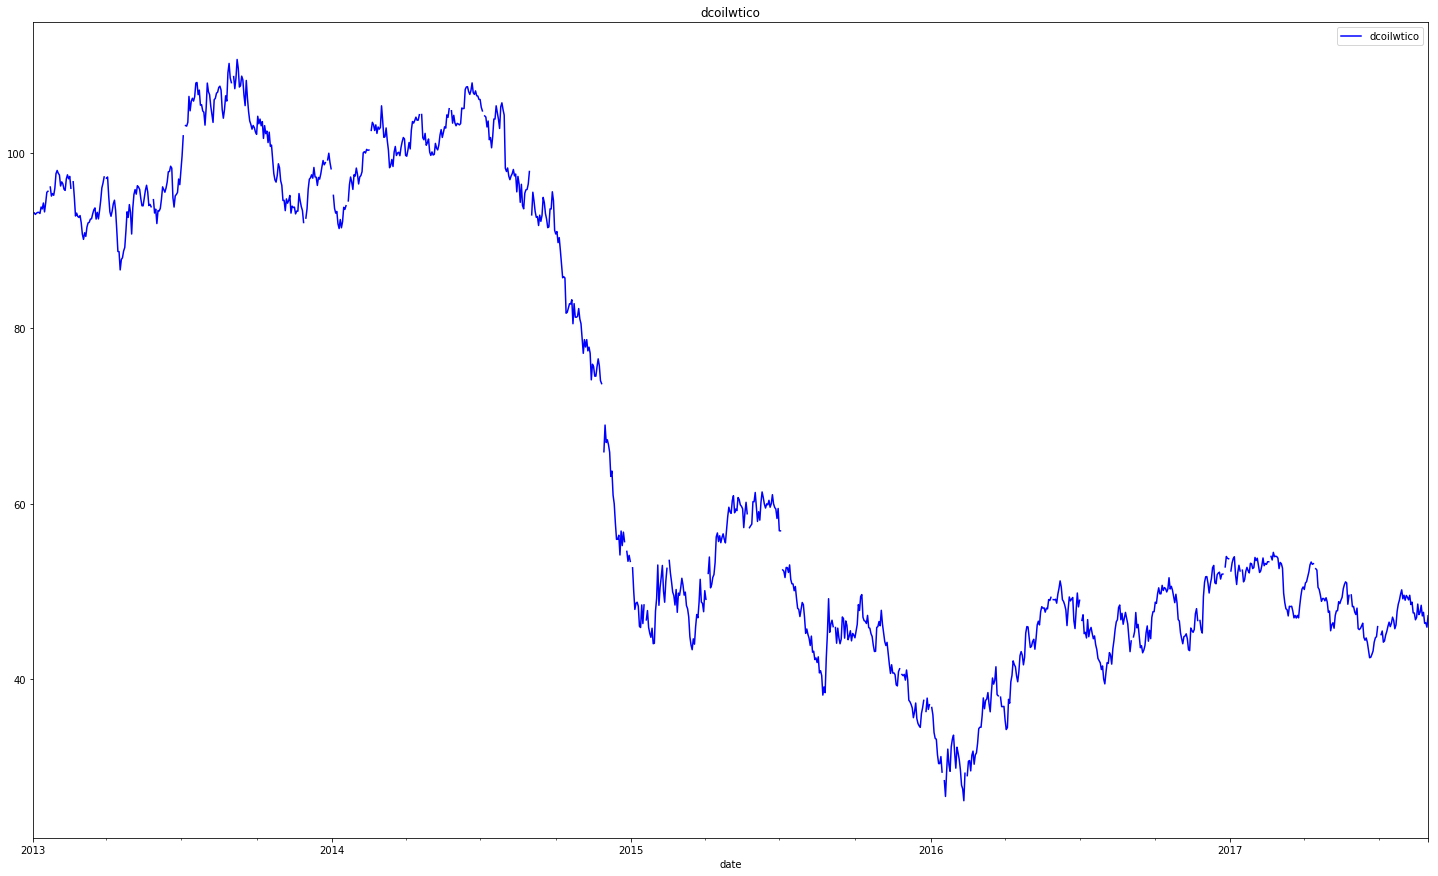

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
df_oil.plot.line(x="date", y="dcoilwtico", color='b', title ="dcoilwtico", ax = axes, rot=0)
plt.show()

In [12]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [13]:
# check grouped data
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w

date         mean
0   2013-01-06  1883.203463
1   2013-01-13  1641.090062
2   2013-01-20  1639.024845
3   2013-01-27  1609.816770
4   2013-02-03  1685.263975
..         ...          ...
237 2017-07-23  1623.208995
238 2017-07-30  1619.653439
239 2017-08-06  1713.743386
240 2017-08-13  1599.156085
241 2017-08-20  1592.675926

[242 rows x 2 columns]

In [14]:
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [15]:
df_grouped_train_w = add_time(df_train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(df_train, 'date', 'M', 'sales')

df_grouped_train_w.head() # check results

date  time        mean
0 2013-01-06     0  206.843478
1 2013-01-13     1  190.285220
2 2013-01-20     2  189.835452
3 2013-01-27     3  182.152050
4 2013-02-03     4  198.564267

# 3.1. Linear Regression

### Bundan sonra, birkaç görsel daha inşa edebiliriz.

#### Doğrusal regresyon pratikte yaygın olarak kullanılır ve karmaşık tahmin görevlerine bile doğal olarak uyum sağlar.
#### Doğrusal regresyon algoritması, girdi özelliklerinden ağırlıklı bir toplam yapmayı öğrenir..

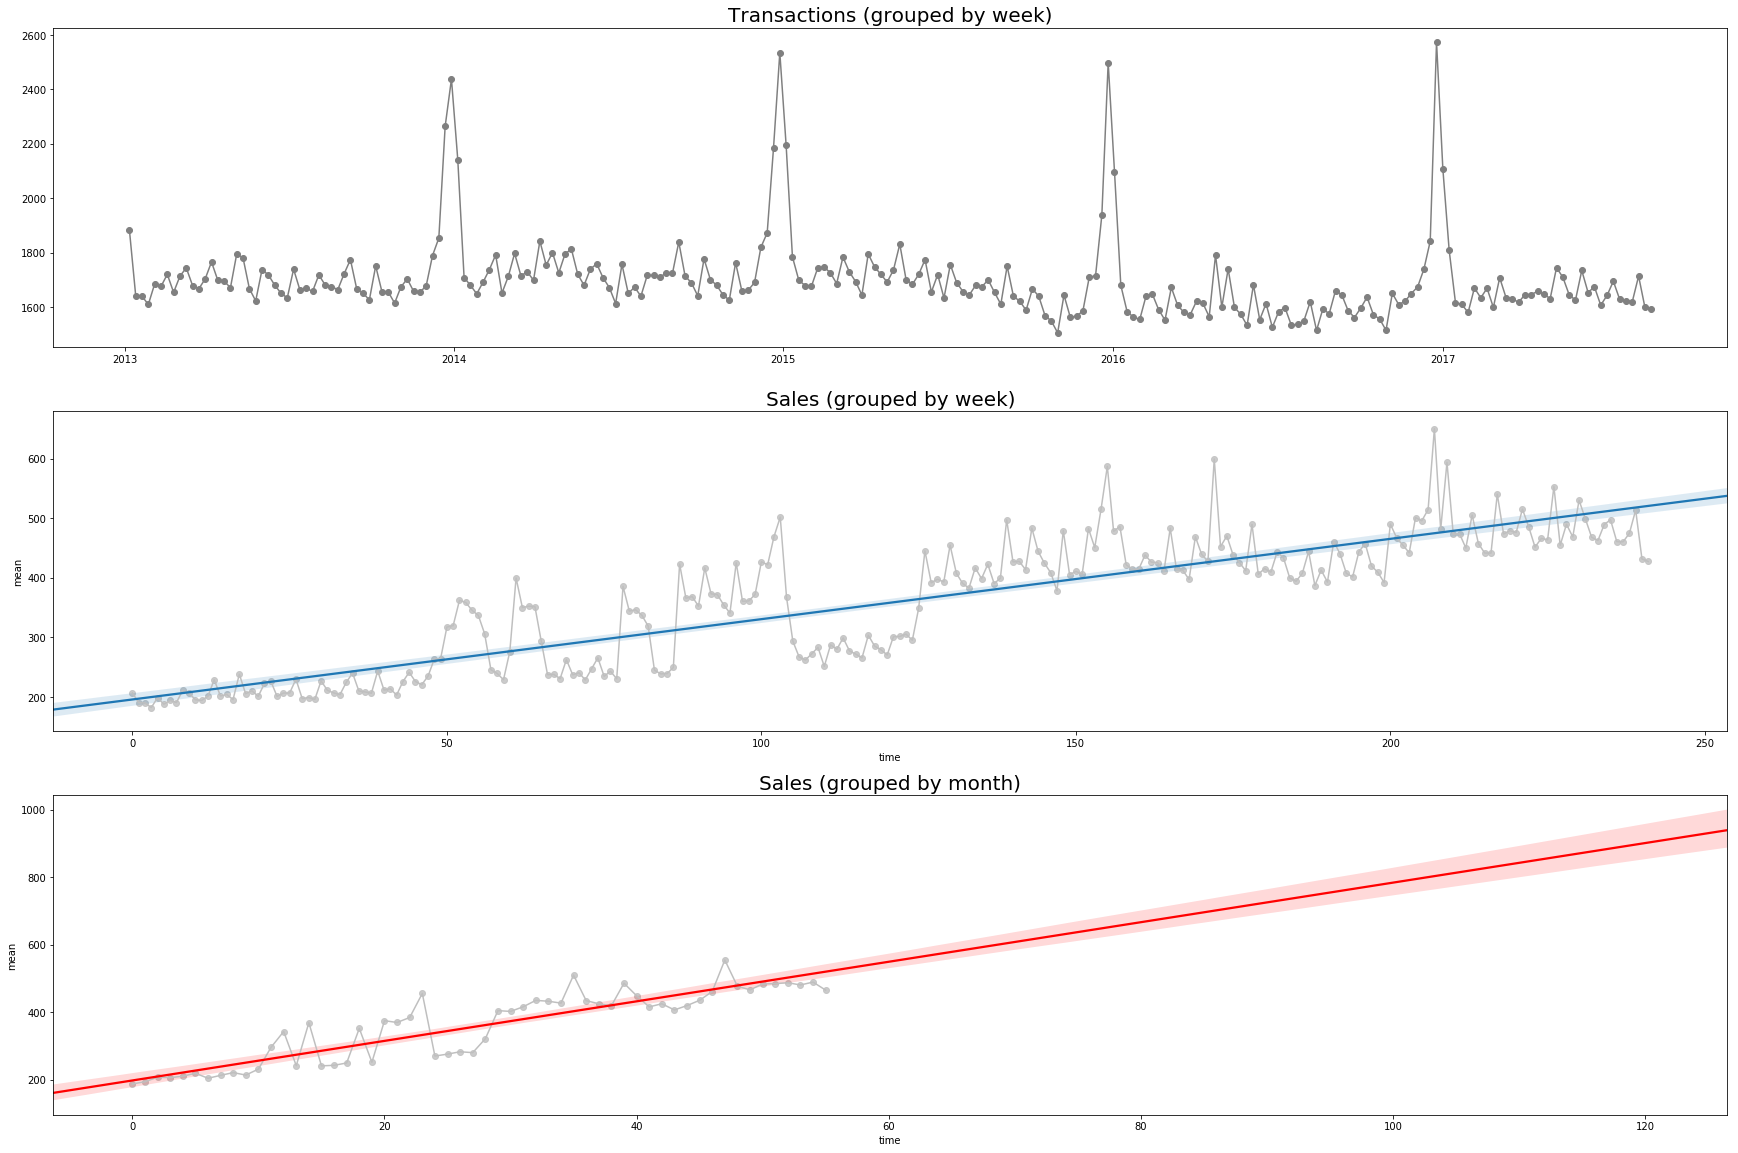

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20))

# TRANSACTIONS (WEEKLY)
axes[0].plot('date', 'mean', data=df_grouped_trans_w, color='grey', marker='o')
axes[0].set_title("Transactions (grouped by week)", fontsize=20)

# SALES (WEEKLY)
axes[1].plot('time', 'mean', data=df_grouped_train_w, color='0.75')
axes[1].set_title("Sales (grouped by week)", fontsize=20)
# linear regression
axes[1] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_w, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[1])

# SALES (MONTHLY)
axes[2].plot('time', 'mean', data=df_grouped_train_m, color='0.75')
axes[2].set_title("Sales (grouped by month)", fontsize=20)
# linear regression
axes[2] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_m, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[2])

plt.show()

# 3.2 Lag feature
Gecikme özelliği yapmak için
hedef serinin gözlemlerini, zaman içinde daha sonra gerçekleşmiş gibi görünecek şekilde kaydırırız. Burada 1 adımlı bir gecikme özelliği oluşturduk, ancak birden fazla adımla kaydırma da mümkün. O halde öncelikle verilerimize lag eklemeliyiz:

Öncelikle elimizdeki verileri daha düzenli bir formata getirelim.
Elimizdeki sales verisi ile bir önceki sales verisini aynı satıra getirip karşılaştırma yapmaya çalışalım.


In [17]:
def add_lag(df, key, freq, col, lag):
    """ ADD LAG """
    df_grouped = grouped(df, key, freq, col)
    name = 'Lag_' + str(lag)
    df_grouped['Lag'] = df_grouped['mean'].shift(lag)
    return df_grouped

In [18]:
df_grouped_train_w_lag1 = add_lag(df_train, 'date', 'W', 'sales', 1)
df_grouped_train_m_lag1 = add_lag(df_train, 'date', 'W', 'sales', 1)

df_grouped_train_w_lag1.head() # check data

date        mean         Lag
0 2013-01-06  206.843478         NaN
1 2013-01-13  190.285220  206.843478
2 2013-01-20  189.835452  190.285220
3 2013-01-27  182.152050  189.835452
4 2013-02-03  198.564267  182.152050

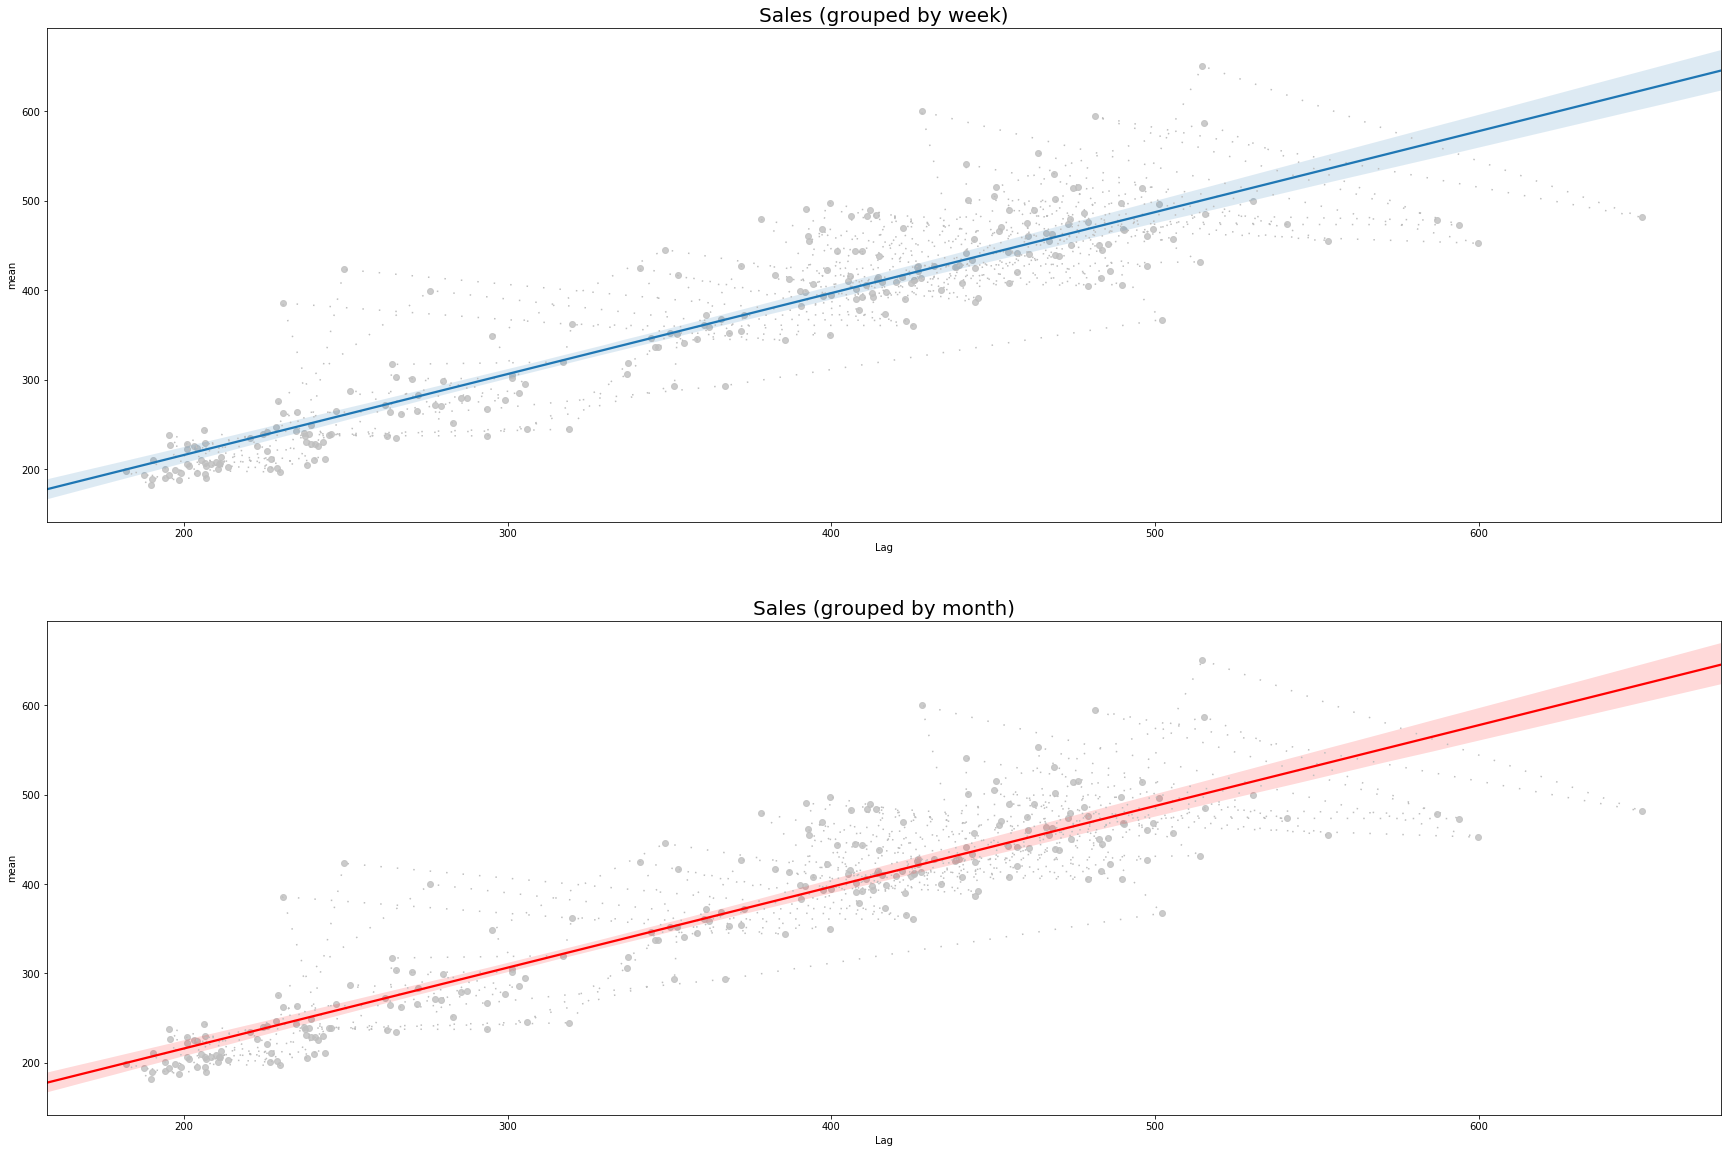

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,20))
axes[0].plot('Lag', 'mean', data=df_grouped_train_w_lag1, color='0.75', linestyle=(0, (1, 10)))
axes[0].set_title("Sales (grouped by week)", fontsize=20)
axes[0] = sns.regplot(x='Lag', 
                      y='mean', 
                      data=df_grouped_train_w_lag1, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[0])


axes[1].plot('Lag', 'mean', data=df_grouped_train_m_lag1, color='0.75', linestyle=(0, (1, 10)))
axes[1].set_title("Sales (grouped by month)", fontsize=20)
axes[1] = sns.regplot(x='Lag', 
                      y='mean', 
                      data=df_grouped_train_m_lag1, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[1])

plt.show()

# Biraz daha istatistik ve görselleştirme
Bu blokta verileri keşfedeceğiz. İlk olarak, her veri kümesindeki her kategori için değer sayımları value_counts() sayalım:

In [20]:
def plot_stats(df, column, ax, color, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

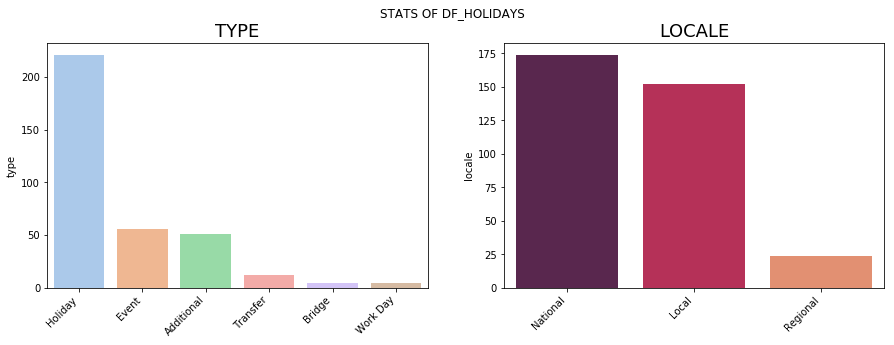

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.autofmt_xdate()
fig.suptitle("Stats of df_holidays".upper())
plot_stats(df_holidays, "type", axes[0], "pastel", 45)
plot_stats(df_holidays, "locale", axes[1], "rocket", 45)
plt.show()

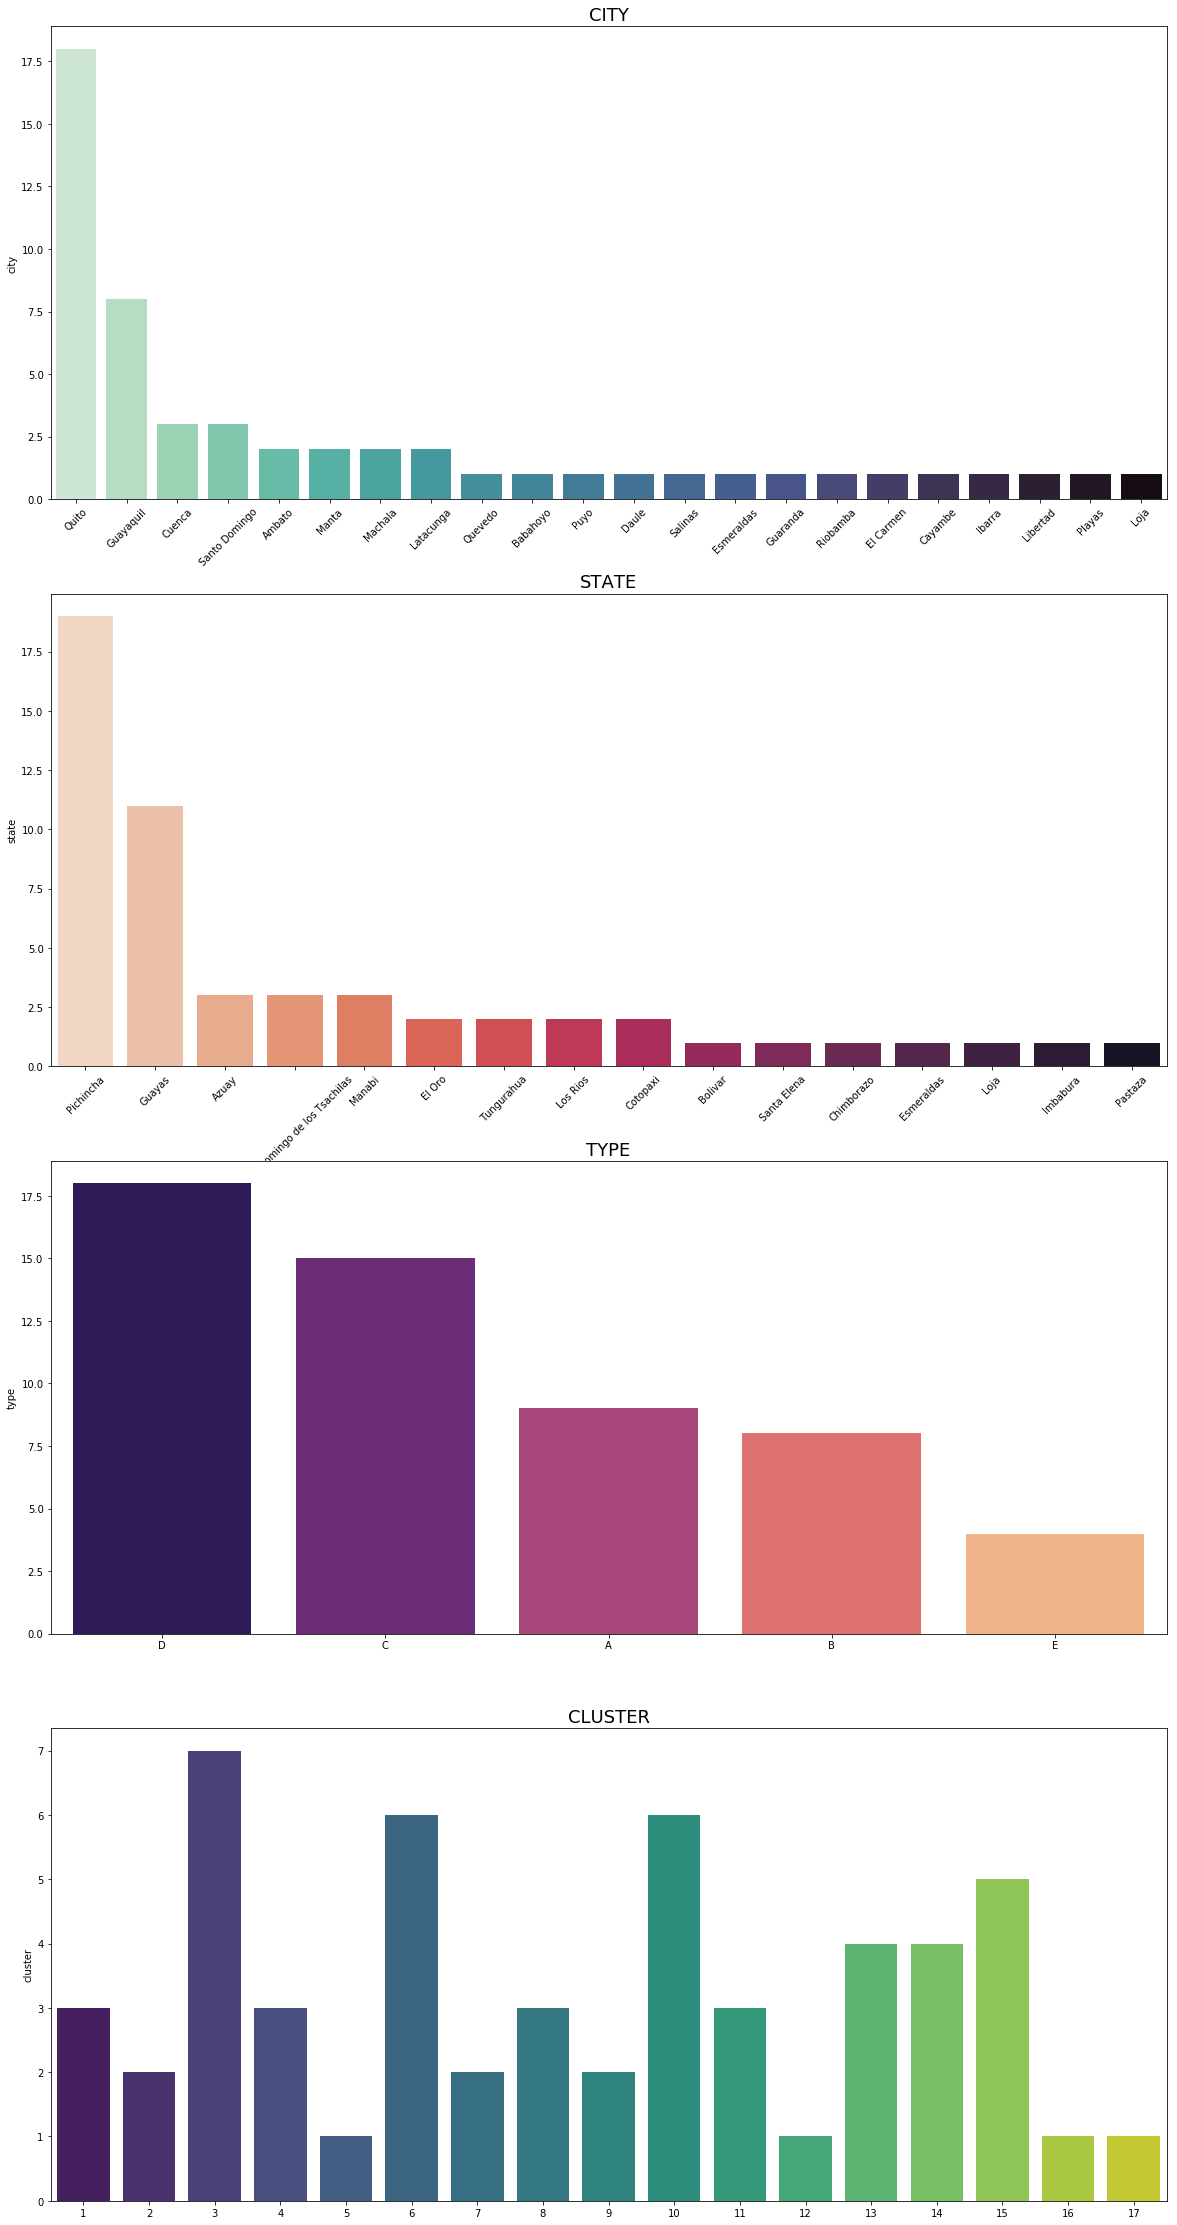

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,40))
plot_stats(df_stores, "city", axes[0], "mako_r", 45)
plot_stats(df_stores, "state", axes[1], "rocket_r", 45)
plot_stats(df_stores, "type", axes[2], "magma", 0)
plot_stats(df_stores, "cluster", axes[3], "viridis", 0)
plt.show()

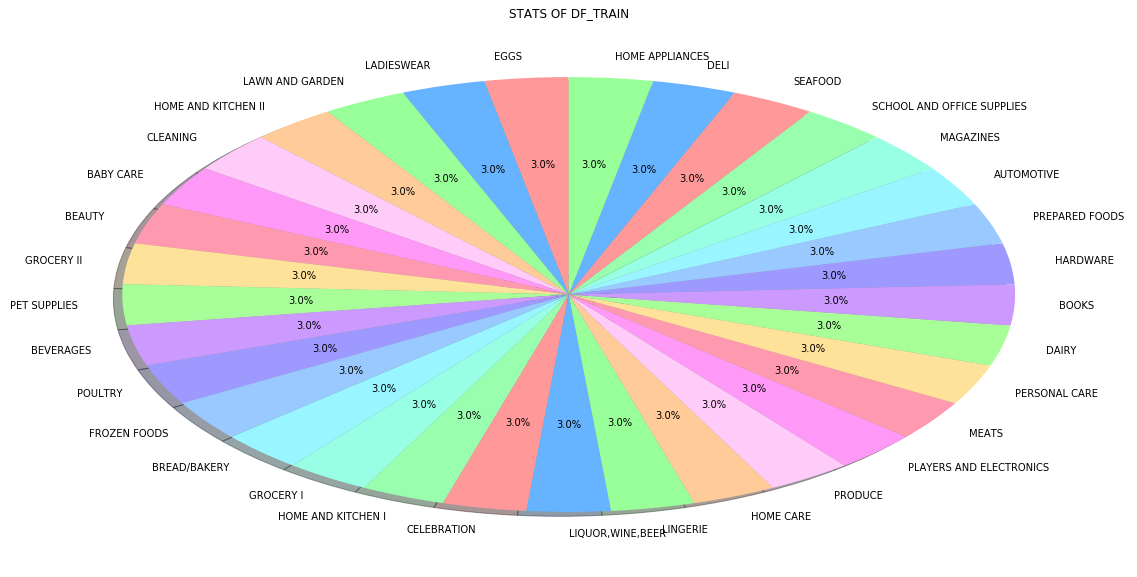

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
count_classes = df_train['family'].value_counts()
plt.title("Stats of df_train".upper())
colors = ['#ff9999','#66b3ff','#99ff99',
          '#ffcc99', '#ffccf9', '#ff99f8', 
          '#ff99af', '#ffe299', '#a8ff99',
          '#cc99ff', '#9e99ff', '#99c9ff',
          '#99f5ff', '#99ffe4', '#99ffaf']

plt.pie(count_classes, 
        labels = count_classes.index, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90, 
        colors=colors)

plt.show()

# 3.4 BoxPlot
Ek olarak, bazı kutu grafikleri oluşturabiliriz: df_oil & df_trans için.

In [24]:
def plot_boxplot(palette, x, y, hue, ax, title):
    sns.set(style="ticks", palette=palette)
    ax = sns.boxplot(x=x, y=y, hue=hue, ax=ax)
    ax.set_title(title, fontsize=18)

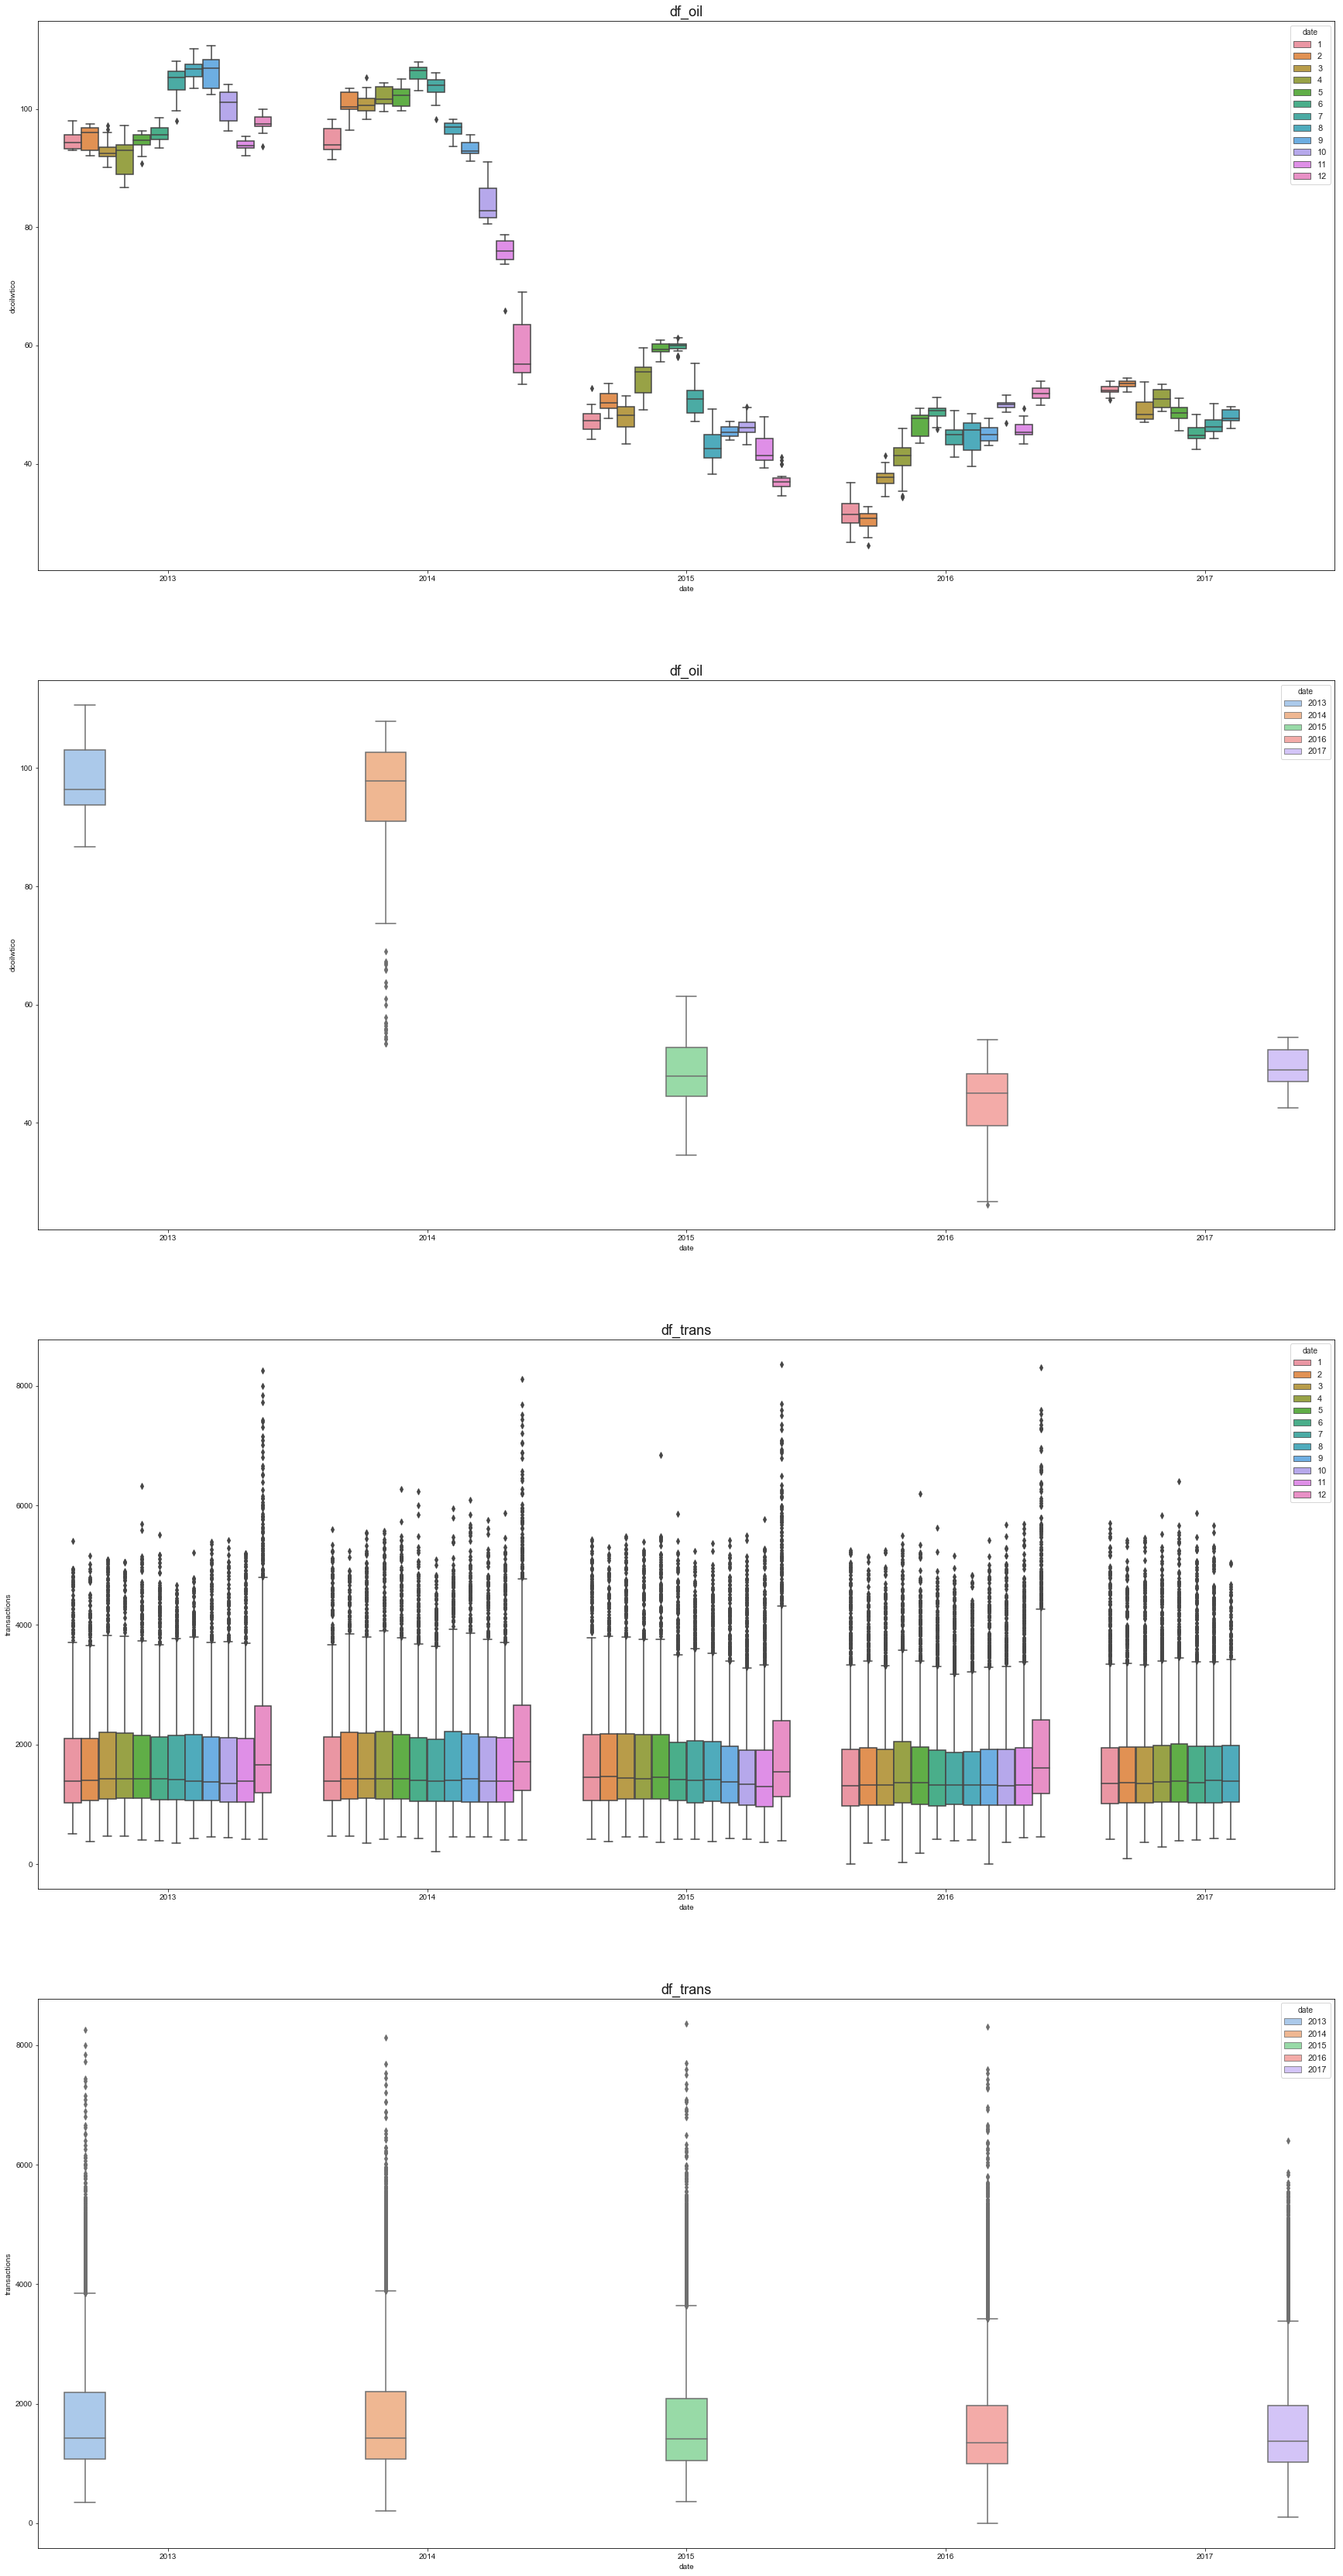

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,60))
plot_boxplot("pastel", df_oil['date'].dt.year, df_oil['dcoilwtico'], df_oil['date'].dt.month, axes[0], "df_oil")
plot_boxplot("pastel", df_oil['date'].dt.year, df_oil['dcoilwtico'], df_oil['date'].dt.year, axes[1], "df_oil")
plot_boxplot("pastel", df_trans['date'].dt.year, df_trans['transactions'], df_trans['date'].dt.month, axes[2], "df_trans")
plot_boxplot("pastel", df_trans['date'].dt.year, df_trans['transactions'], df_trans['date'].dt.year, axes[3], "df_trans")
plt.show()

# 3.5 Trend. Moving Average(Akım. Hareketli ortalama)

Bir zaman serisinin trend bileşeni, serinin ortalamasında kalıcı, uzun vadeli bir değişikliği temsil eder. Trend, bir serinin en yavaş hareket eden kısmıdır, en büyük zaman ölçeğini temsil eden kısımdır. Ürün satışlarının bir zaman serisinde, yıldan yıla daha fazla insan üründen haberdar oldukça pazar genişlemesinin etkisi artan bir eğilim olabilir.

Bir zaman serisinin ne tür bir eğilimi olabileceğini görmek için hareketli ortalama grafiğini kullanabiliriz. Bir zaman serisinin hareketli ortalamasını hesaplamak için, belirli bir genişlikteki kayan bir pencere içindeki değerlerin ortalamasını hesaplıyoruz. Grafikteki her nokta, serideki her iki taraftaki pencerenin içine düşen tüm değerlerin ortalamasını temsil eder. Buradaki fikir, yalnızca uzun vadeli değişikliklerin kalması için serideki kısa vadeli dalgalanmaları düzeltmektir.

Aşağıda, İşlemler ve Satışlar için yeşil renkli hareketli ortalama grafiklerini görebiliriz.

In [26]:
def plot_moving_average(df, key, freq, col, window, min_periods, ax, title):
    df_grouped = grouped(df, key, freq, col)
    moving_average = df_grouped['mean'].rolling(window=window, center=True, min_periods=min_periods).mean()   
    ax = df_grouped['mean'].plot(color='0.75', linestyle='dashdot', ax=ax)
    ax = moving_average.plot(linewidth=3, color='g', ax=ax)
    ax.set_title(title, fontsize=18)

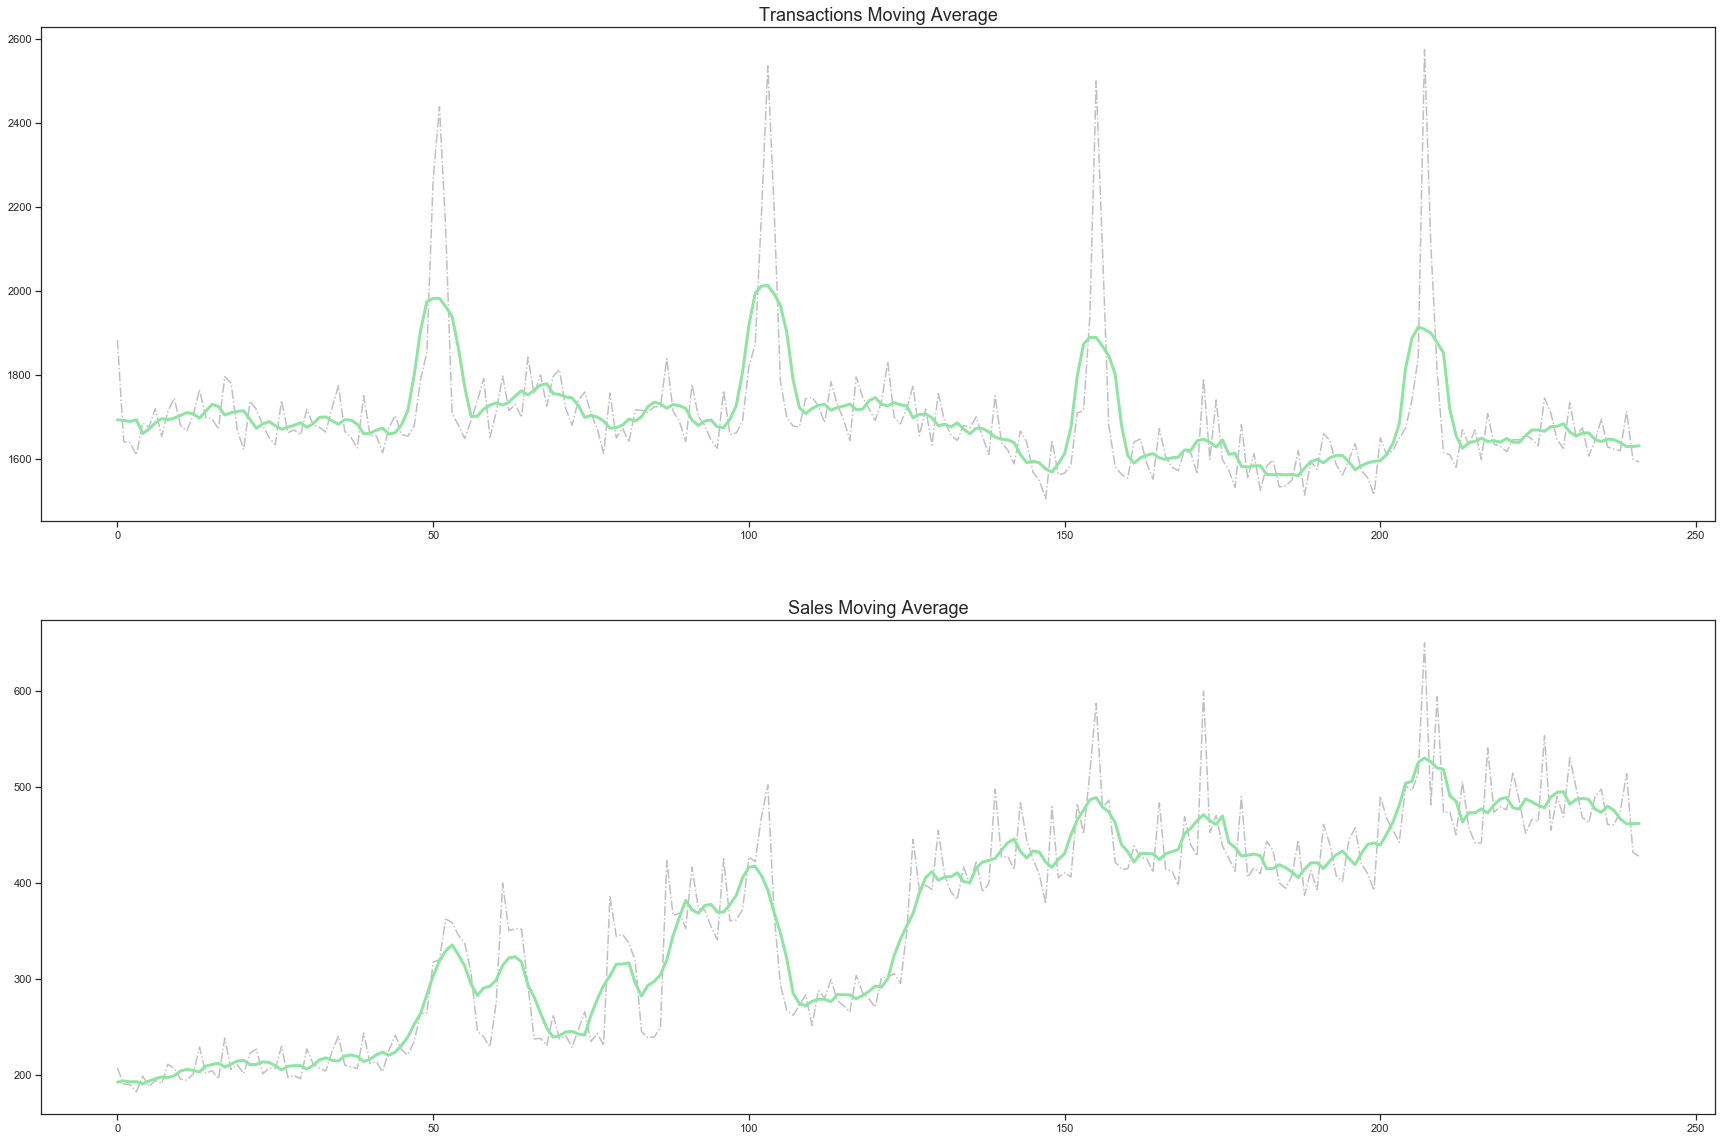

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,20))
plot_moving_average(df_trans, 'date', 'W', 'transactions', 7, 4, axes[0], 'Transactions Moving Average')
plot_moving_average(df_train, 'date', 'W', 'sales', 7, 4, axes[1], 'Sales Moving Average')
plt.show()

# 3.6. Trend. Forecasting Trend - Trend Akım Tahminleme

DeterministicProcess adlı statsmodels kitaplığındaki bir işlevi kullanacağız.
Bu işlevi kullanmak, zaman serileri ve doğrusal regresyon ile ortaya çıkabilecek bazı zor hata durumlarından kaçınmamıza yardımcı olacaktır. Sıra argümanı polinom sırasını ifade eder: doğrusal için 1, ikinci dereceden için 2, kübik için 3 vb.

In [28]:
def plot_deterministic_process(df, key, freq, col, ax1, title1, ax2, title2):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    dp = DeterministicProcess(index=df_grouped['date'], constant=True, order=1, drop=True)
    dp.index.freq = freq # manually set the frequency of the index
    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index
    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    ax1 = y1.plot(linestyle='dashed', label="mean", color="0.75", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Trend", color='b', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()
    
    # forecast Trend for future 30 steps
    steps = 30 
    X2 = dp.out_of_sample(steps=steps)
    y2_fore = pd.Series(model.predict(X2), index=X2.index)
    y2_fore.head()
    ax2 = y1.plot(linestyle='dashed', label="mean", color="0.75", ax=ax2, use_index=True)
    ax2 = y1_pred.plot(linewidth=3, label="Trend", color='b', ax=ax2, use_index=True)
    ax2 = y2_fore.plot(linewidth=3, label="Predicted Trend", color='r', ax=ax2, use_index=True)
    ax2.set_title(title2, fontsize=18)  
    _ = ax2.legend()

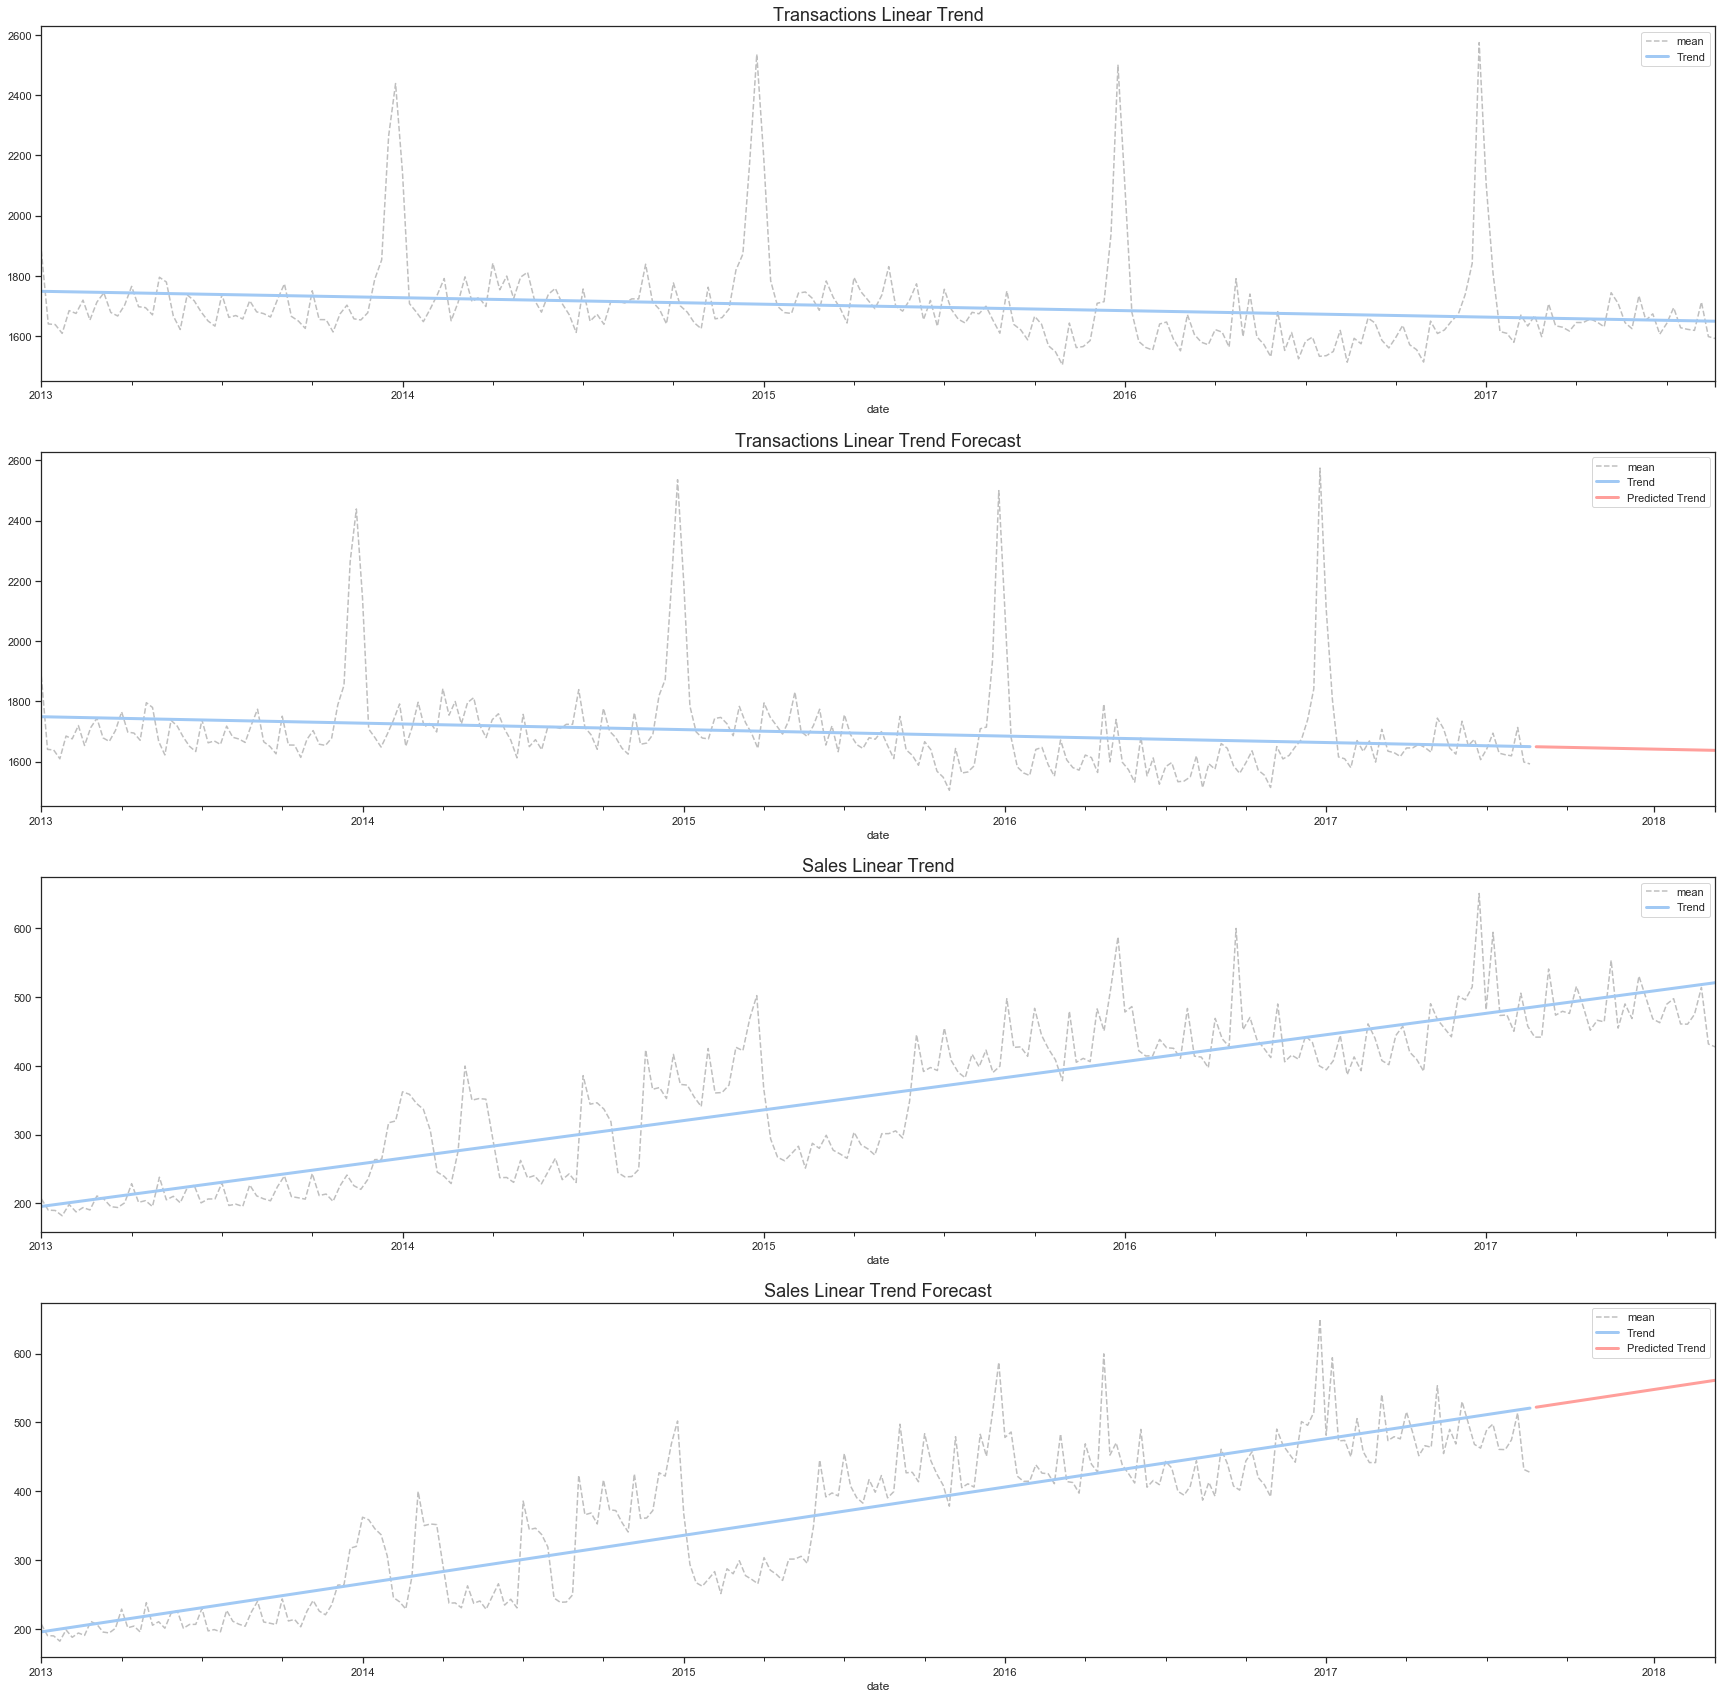

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,30))
plot_deterministic_process(df_trans, 'date', 'W', 'transactions', 
                           axes[0], "Transactions Linear Trend",  
                           axes[1], "Transactions Linear Trend Forecast")
plot_deterministic_process(df_train, 'date', 'W', 'sales', 
                           axes[2], "Sales Linear Trend", 
                           axes[3], "Sales Linear Trend Forecast")
plt.show()

# 3.7 Seasonality - Mevsimsellik¶
Zaman serileri, serinin ortalamasında düzenli, periyodik bir değişiklik olduğunda mevsimsellik sergiler. Mevsimsel değişiklikler genellikle saati ve takvimi takip eder - bir gün, bir hafta veya bir yıl boyunca tekrarlar yaygındır.
  Mevsimsellik genellikle doğal dünyanın günler ve yıllar içindeki döngüleri veya tarih ve saatleri çevreleyen sosyal davranış gelenekleri tarafından yönlendirilir. Bir dizideki eğilimi keşfetmek için hareketli bir ortalama grafiği kullandığımız gibi, mevsimsel kalıpları keşfetmek için mevsimsel bir grafik kullanabiliriz.

In [30]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

In [31]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [32]:
def seasonality(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d")
    df_grouped.index = df_grouped['date'] 
    df_grouped = df_grouped.drop(columns=['date'])
    df_grouped.index.freq = freq # manually set the frequency of the index
    
    X = df_grouped.copy()
    X.index = pd.to_datetime(X.index, format = "%Y-%m-%d") 
    X.index.freq = freq 
    # days within a week
    X["day"] = X.index.dayofweek   # the x-axis (freq)
    X["week"] = pd.Int64Index(X.index.isocalendar().week)  # the seasonal period (period)
    # days within a year
    X["dayofyear"] = X.index.dayofyear
    X["year"] = X.index.year
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 30))
    seasonal_plot(X, y='mean', period="week", freq="day", ax=ax0)
    seasonal_plot(X, y='mean', period="year", freq="dayofyear", ax=ax1)
    X_new = (X['mean'].copy()).dropna()
    plot_periodogram(X_new, ax=ax2)

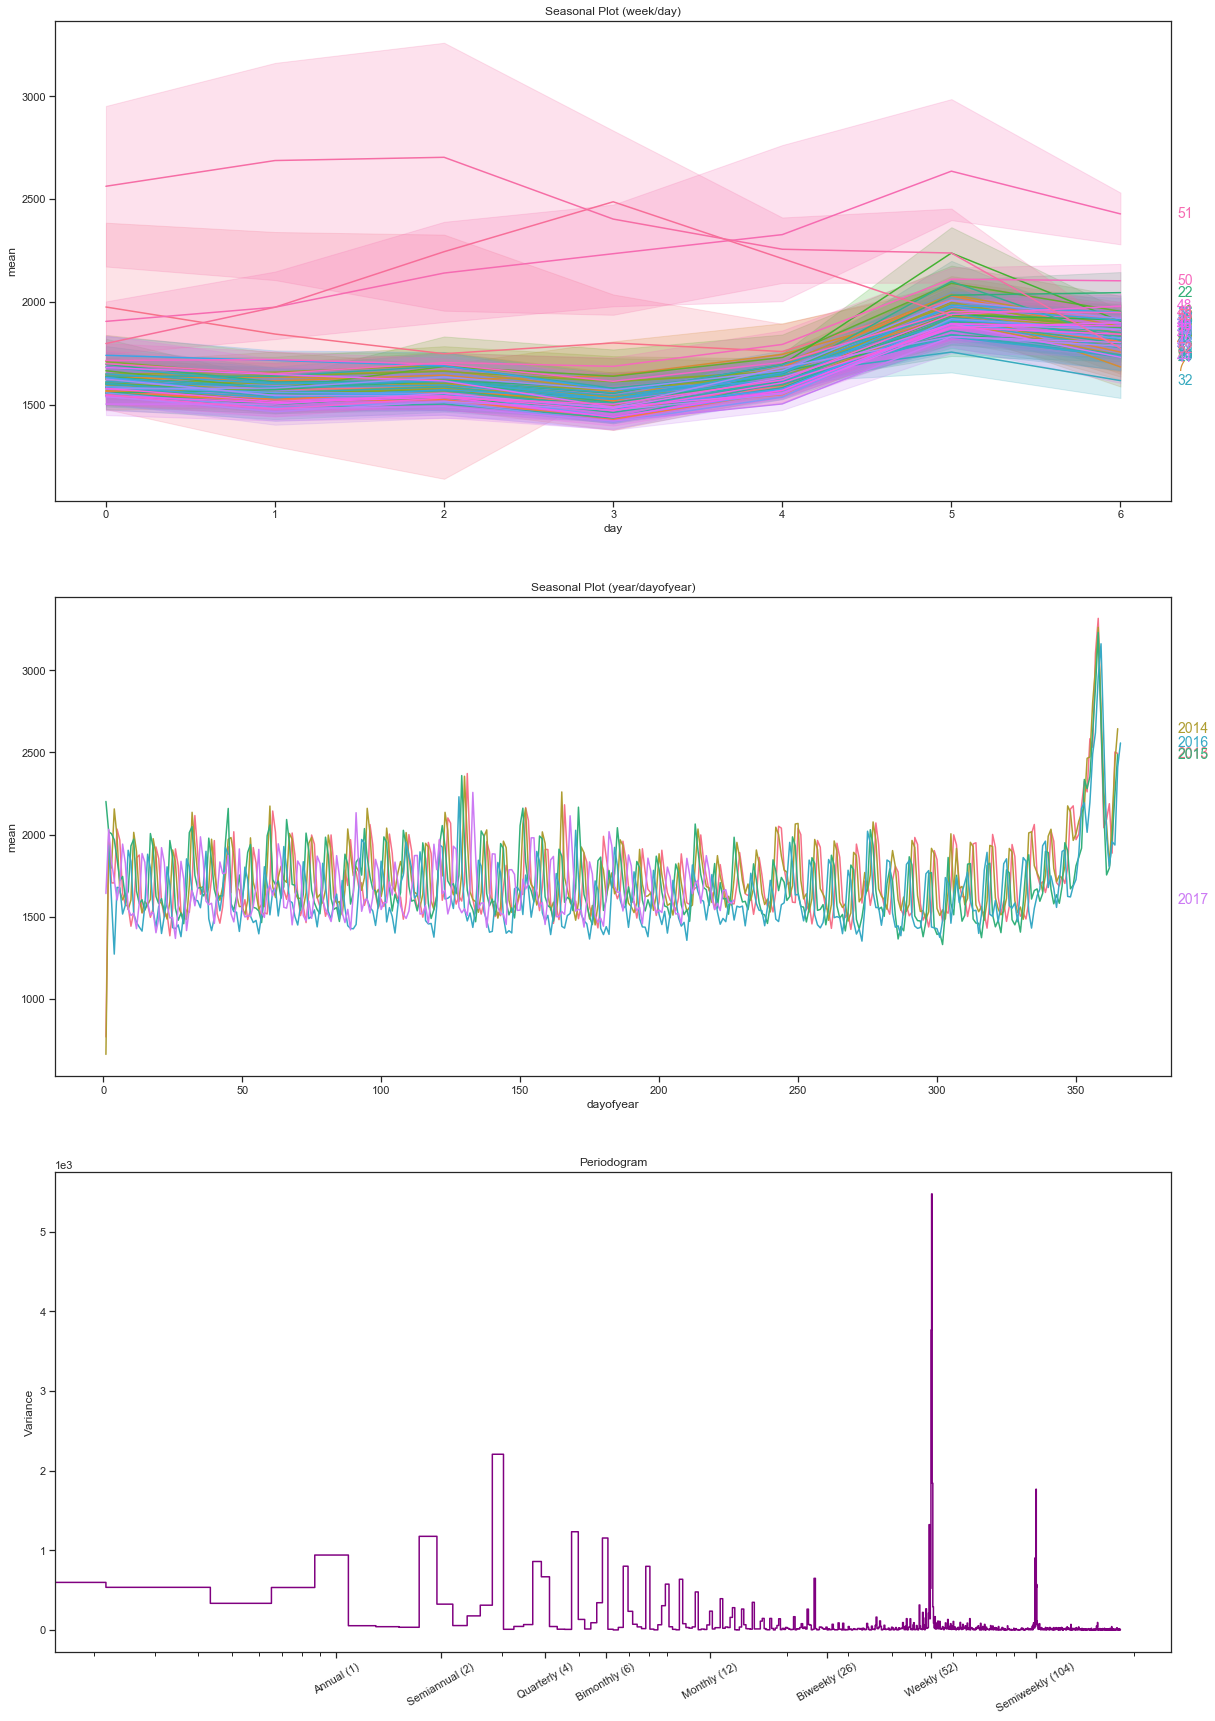

In [33]:
# df_trans, grouped by day
seasonality(df_trans, 'date', 'D', 'transactions')

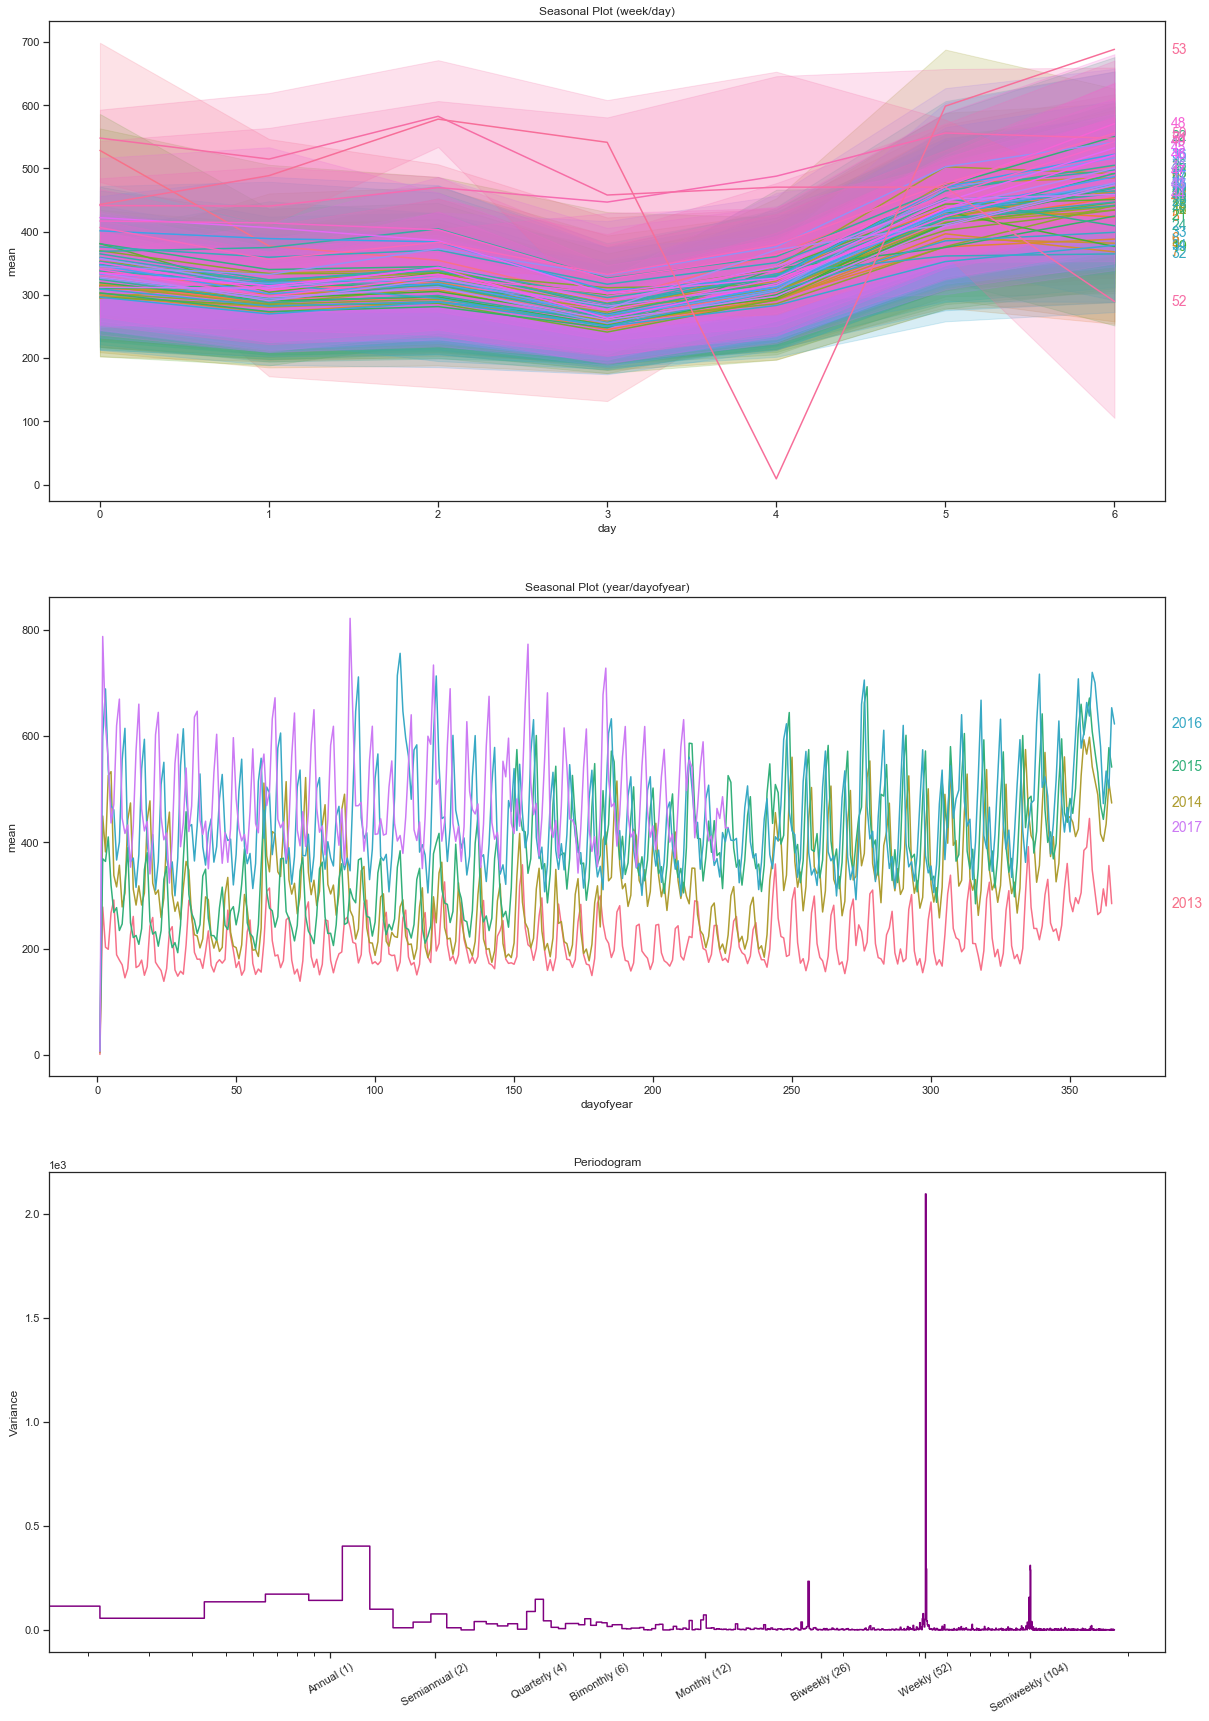

In [34]:
# df_train, grouped by day
seasonality(df_train, 'date', 'D', 'sales')

* Böylece Trend için kullandığımız gibi DeterministicProcess kullanarak mevsimselliği tahmin edebiliriz. 
* İşlemler ve Satışlar için mevsimsellik tahmininde bulunacağız.

In [35]:
def predict_seasonality(df, key, freq, col, ax1, title1):
    fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    df_grouped['date'].freq = freq # manually set the frequency of the index
    dp = DeterministicProcess(index=df_grouped['date'], 
                              constant=True, 
                              order=1, 
                              period=None, 
                              seasonal=True, 
                              additional_terms=[fourier], 
                              drop=True)
    dp.index.freq = freq # manually set the frequency of the index

    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index

    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    X1_fore = dp.out_of_sample(steps=90)
    y1_fore = pd.Series(model.predict(X1_fore), index=X1_fore.index)
    
    ax1 = y1.plot(linestyle='dashed', style='.', label="init mean values", color="0.4", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Seasonal", color='b', ax=ax1, use_index=True)
    ax1 = y1_fore.plot(linewidth=3, label="Seasonal Forecast", color='r', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()

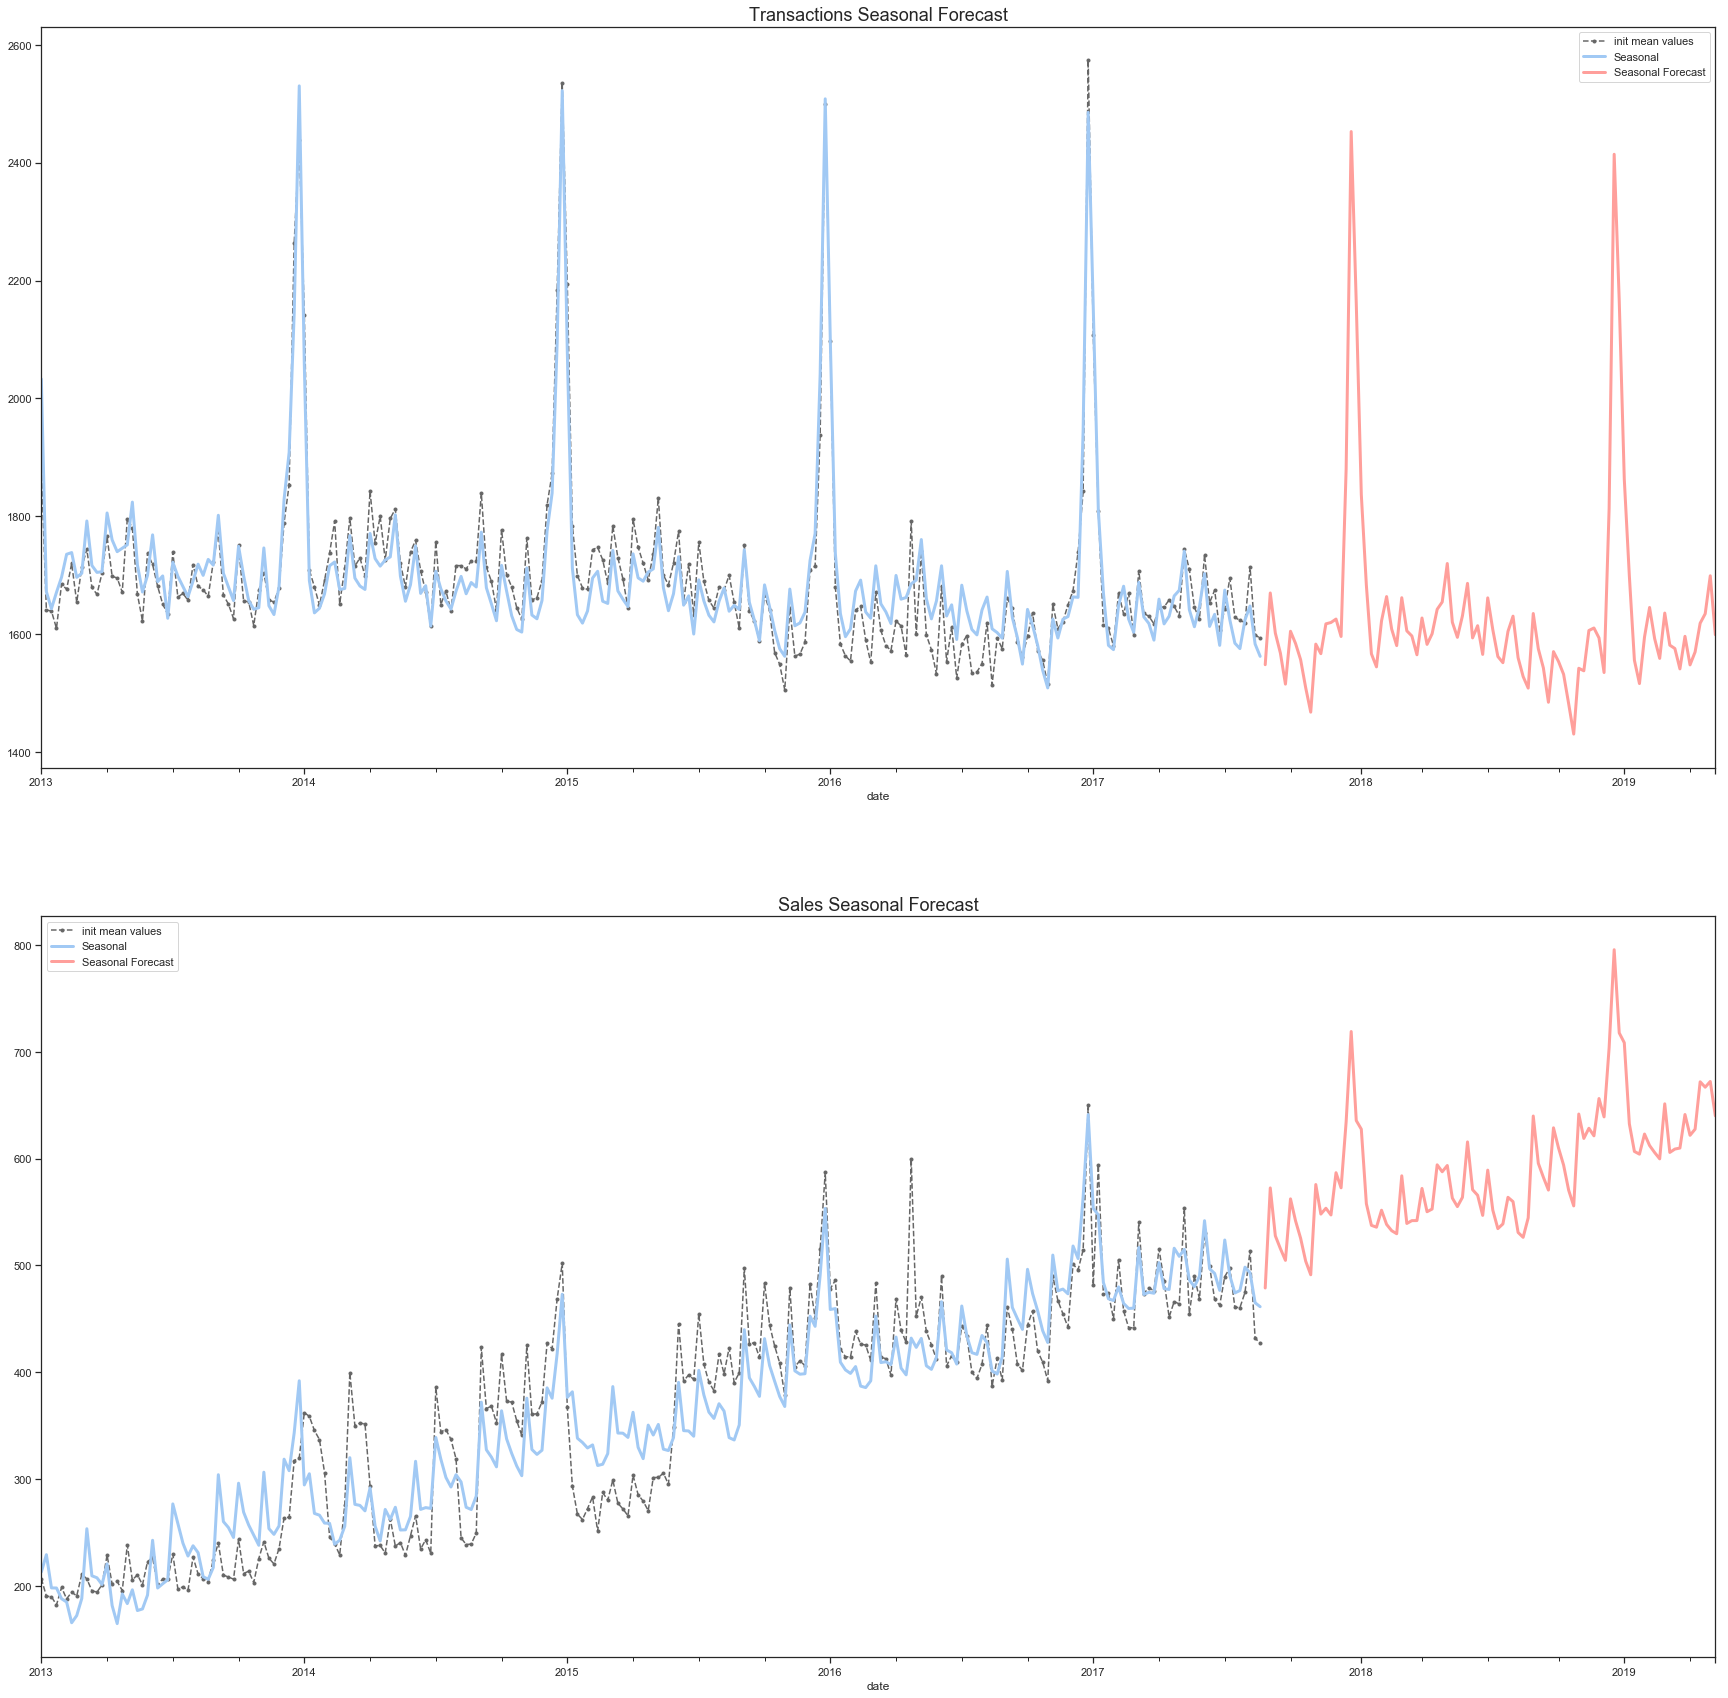

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,30))
predict_seasonality(df_trans, 'date', 'W', 'transactions', axes[0], "Transactions Seasonal Forecast")
predict_seasonality(df_train, 'date', 'W', 'sales', axes[1], "Sales Seasonal Forecast")
plt.show()

# 4. Time Series as Features

In [36]:
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

In [37]:
store_sales.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0          0.0
                     2013-01-02  1782    2.0          0.0
                     2013-01-03  3564    3.0          0.0
                     2013-01-04  5346    3.0          0.0
                     2013-01-05  7128    5.0          0.0

In [38]:
mag_sales.head()

sales onpromotion
family     MAGAZINES   MAGAZINES
date                            
2017-01-01  0.074074    0.074074
2017-01-02  7.777778    2.759259
2017-01-03  3.500000    2.092593
2017-01-04  3.500000    1.833333
2017-01-05  3.203704    1.981481

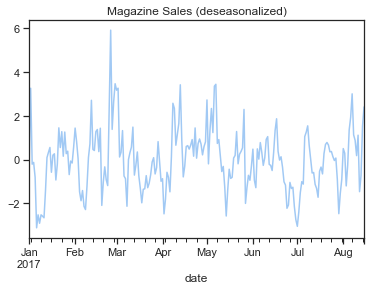

In [39]:
y = mag_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)");

##### Bir zaman serisini geciktirerek, geçmiş değerlerinin tahmin etmeye çalıştığımız değerlerle (yani aynı satırda) eşzamanlı görünmesini sağlayabiliriz. Bu, gecikmeli serileri seri bağımlılığı modellemek için özellikler olarak kullanışlı hale getirir. Serileri tahmin etmek için, y hedefini tahmin etmek için özellikler olarak y_lag_1 ve y_lag_2 kullanabiliriz.

# 4.1 Lag plot - Gecikme Grafiği
Bir zaman serisinin gecikme grafiği, gecikmelerine karşı çizilen değerlerini gösterir. Bir zaman serisindeki seri bağımlılık, genellikle bir gecikme grafiğine bakılarak belirgin hale gelecektir. Seri bağımlılığın en yaygın olarak kullanılan ölçüsü, bir zaman serisinin gecikmelerinden biriyle olan korelasyonu olan otokorelasyon olarak bilinir. Kısmi otokorelasyon size önceki tüm gecikmeleri hesaba katan bir gecikmenin korelasyonunu söyler - tabiri caizse gecikmenin katkıda bulunduğu "yeni" korelasyon miktarı. Kısmi otokorelasyonun çizilmesi, hangi gecikme özelliklerini kullanacağınızı seçmenize yardımcı olabilir.

In [40]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75,s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}",prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2 + 10, nrows * 2 + 5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

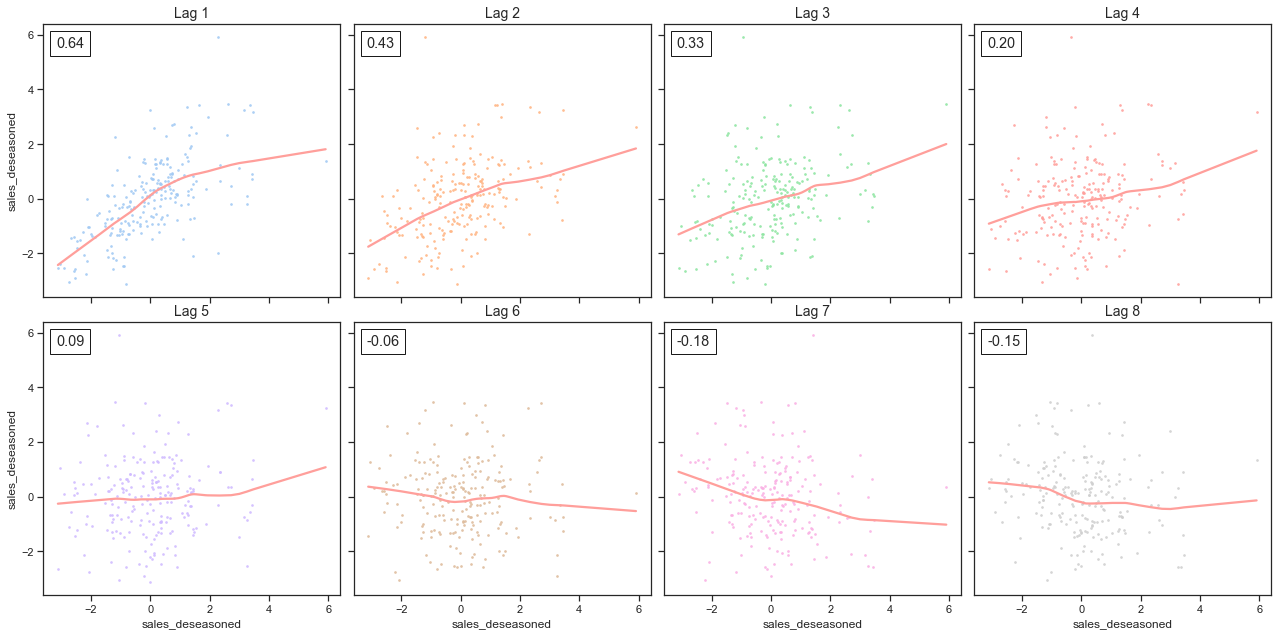

In [41]:
_ = plot_lags(y_deseason, lags=8, nrows=2)

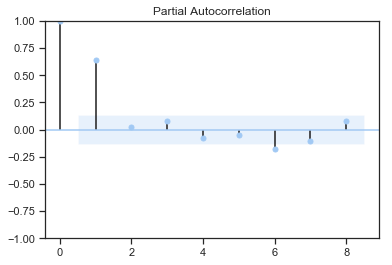

In [42]:
_ = plot_pacf(y_deseason, lags=8)

# Burada, dergi satışlarına karşı çizilen onpromosyon için önde gelen ve gecikmeli değerleri inceliyoruz.

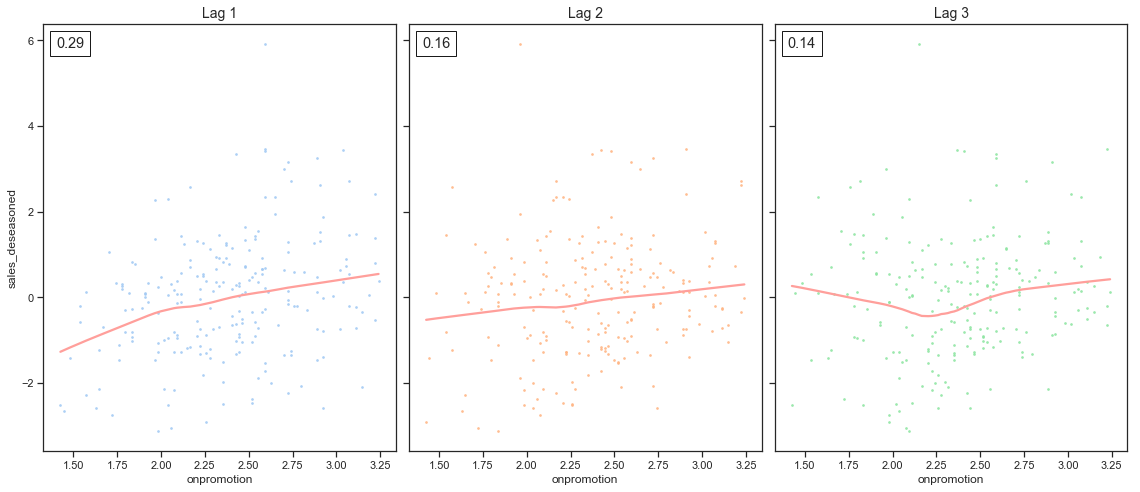

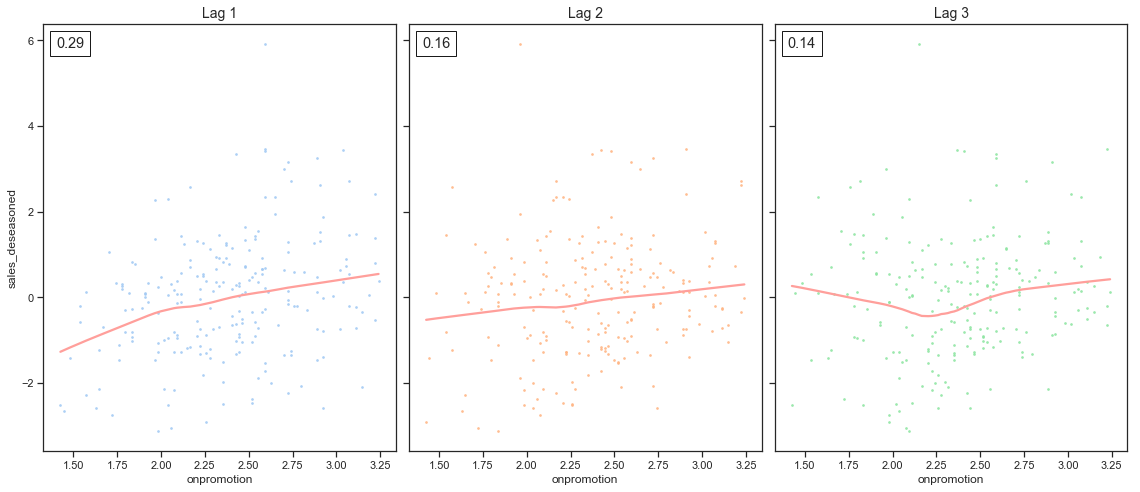

In [43]:
onpromotion = mag_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, nrows=1)

# 4.2 Lags. Forecasting - Gecikme. tahmin
Bundan sonra, gelecekteki arsalar için gecikmeler yapabiliriz.


In [44]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [45]:
X = make_lags(y_deseason, lags=4)
X = X.fillna(0.0)

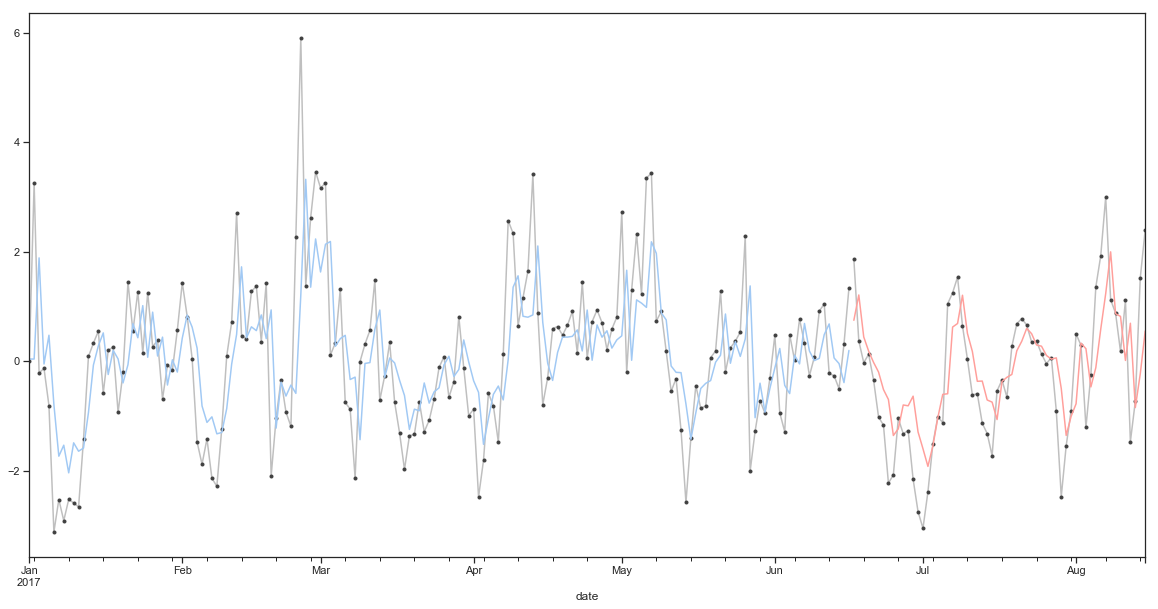

In [46]:
# Create target series and data splits
y = y_deseason.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = y_train.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

# 5. Hybrid Models - Hibrit Modeller

Doğrusal regresyon, eğilimleri tahmin etmede üstündür, ancak etkileşimleri öğrenemez. XGBoost, öğrenme etkileşimlerinde üstündür, ancak eğilimleri tahmin edemez. Burada, tamamlayıcı öğrenme algoritmalarını birleştiren ve birinin güçlü yanlarının diğerinin zayıflığını telafi etmesine izin veren "karma" tahmincilerin nasıl oluşturulacağını öğreneceğiz.

In [47]:
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [48]:
# we'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [49]:
#Also, we need to create fit method:

def fit(self, X_1, X_2, y):
    # train model_1
    self.model_1.fit(X_1, y)

    # make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [50]:
#And predict method:

def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [51]:
#Here we can set up data for training:

# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [52]:
#Here we can train our model:

# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [53]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

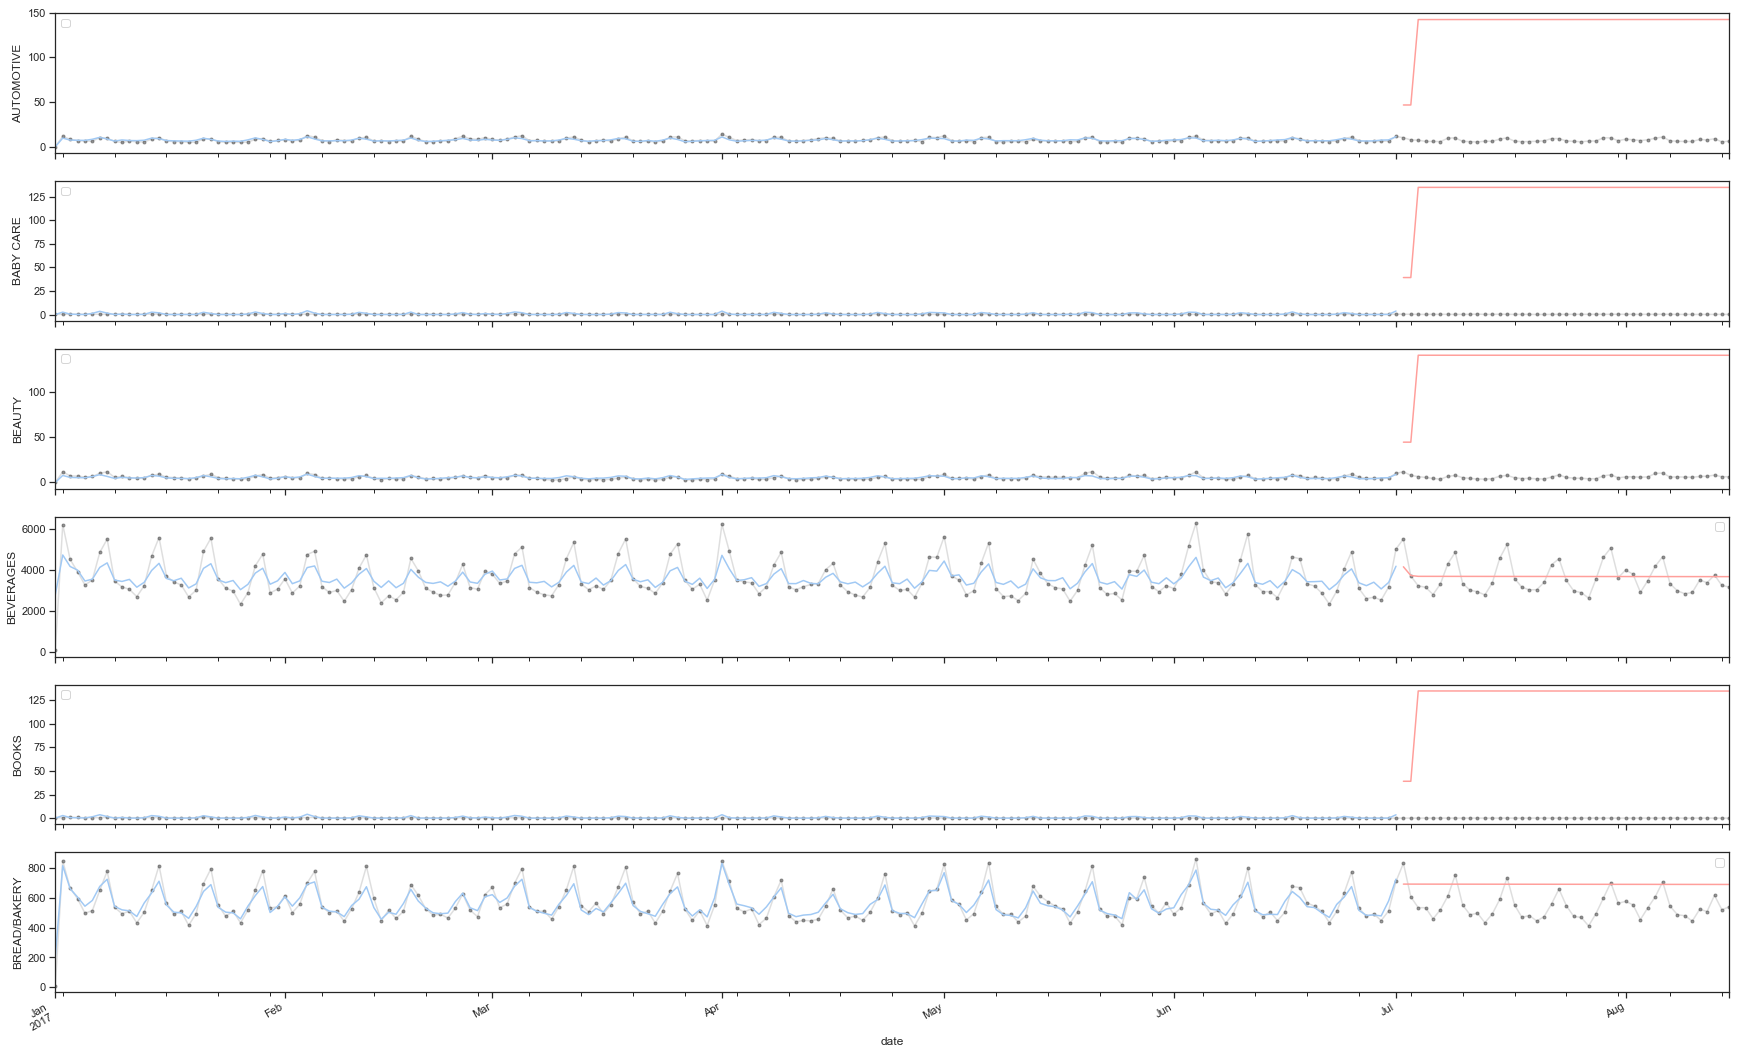

In [54]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# 6. Machine learning forecasting


In [111]:
# train data
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [112]:
# test data
test = df_test.copy()
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [113]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'salesPred_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [114]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [115]:
#Here we prepare the data for XGBoost:

le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)
submission.to_csv("Forecast_Submission.csv", index=False)

salesPred_1  salesPred_2  salesPred_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.018519    10.259259     9.388889   
           BABY CARE                      0.277778     0.259259     0.240741   
           BEAUTY                         6.518519    10.037037    11.611111   
           BEVERAGES                   3507.277778  4848.518519  5503.648148   
           BOOKS                          0.537037     0.481481     0.722222   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                       salesPred_4  salesPred_5  salesPred_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.944444     4.777778     6.314815   
           BABY CARE                      0.444444     0.240741     0.277778   
           BEAUTY                         5.648148     6.500000     5.277778   
           BEVERAGES                   3448.203704  3171.740741  3046.870370   
           BOOKS                          0.500000     0.518519     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                       salesPred_7  salesPred_8  salesPred_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.388889     5.240741     8.500000   
           BABY CARE                      0.296296     0.296296     0.388889   
           BEAUTY                         4.370370     4.703704     7.777778   
           BEVERAGES                   2693.722222  3226.037037  4667.296296   
           BOOKS                          0.388889     0.444444     0.574074   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                       salesPred_10  salesPred_11  \
date       family                                                   
2017-01-06 AUTOMOTIVE                     10.259259      6.407407   
           BABY CARE                       0.425926      0.314815   
           BEAUTY                          9.037037      5.648148   
           BEVERAGES                    5580.611111   3700.370370   
           BOOKS                           0.555556      0.388889   
...                                             ...           ...   
2017-07-31 POULTRY                       305.270204    278.819870   
           PREPARED FOODS                 84.796537     78.791444   
           PRODUCE                      2663.076241   1670.264889   
           SCHOOL AND OFFICE SUPPLIES     53.740741     42.962963   
           SEAFOOD                        18.181426     13.284463   

                  

# 6.1 Forecast with the DirRec strategy-Doğrudan strateji ile tahmin
Doğrudan stratejiyi XGBoost'a uygulayan bir model oluşturun

In [116]:
# init model
model = RegressorChain(base_estimator=XGBRegressor())
# train model
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index,columns=y.columns).clip(0.0)

In [117]:
#Also, we need to define helpfull function, plot_multistep:

# helpful function
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

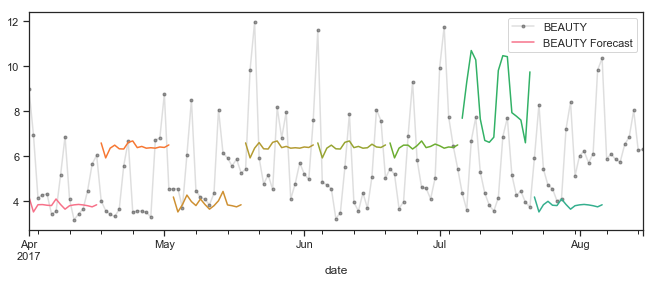

In [135]:
#So, now, we can plot results:

FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [78]:
#submission = pd.DataFrame({ 'FAMILY': [y], 'Sales': [y_pred_] })
#submission.to_csv("my_submission2.csv", index=False)

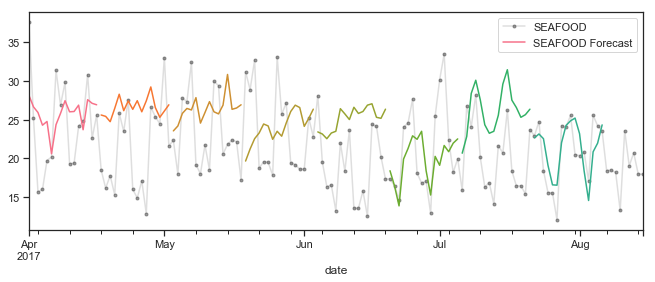

In [134]:
#So, now, we can plot results:

FAMILY = 'SEAFOOD'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])


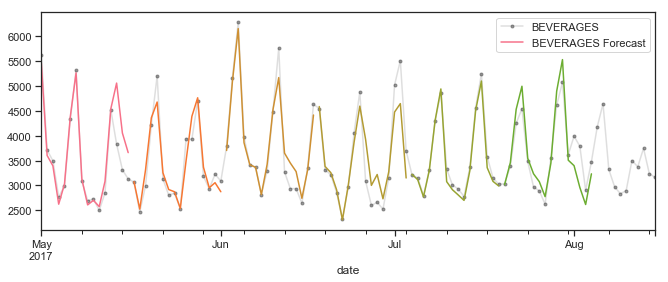

In [133]:
#So, now, we can plot results:

FAMILY = 'BEVERAGES'
START = '2017-05-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])
